In [1]:
from collections import Counter
from google.colab import drive
from prettytable import PrettyTable

import math
import matplotlib.pyplot as plt
import numpy as np
import random
import statistics
import torch

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Experiments/context-projections-clustering

Mounted at /content/drive
/content/drive/MyDrive/Experiments/context-projections-clustering


# Model Class

In [4]:
from model import Model

# Functions

In [5]:
from utils import preprocess, cosine_similarity, orthogonal_projection_position, kmeans_cluster, get_context_projections, get_stats

# Read Text

In [6]:
with open('text8') as f:
    text = f.read()

words = preprocess(text)

print("Total words in text: %d" % (len(words)))
print("Unique words in text: %d" % (len(set(words))))

Total words in text: 8448361
Unique words in text: 63459


## Choosing Test Words

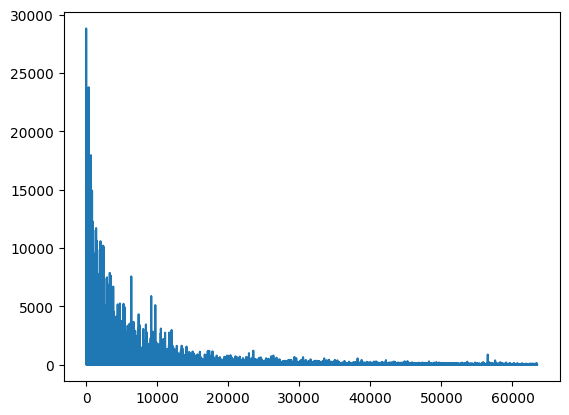

In [7]:
counter = Counter(words)
plt.plot(range(len(counter.keys())), counter.values())
plt.show()

In [8]:
num_samples = 50
test_indexes = np.random.choice(range(100, 20000), size=(num_samples))
test_words = [list(counter.keys())[i] for i in test_indexes]

print("Five of the picked test words: ", test_words[:5])

Five of the picked test words:  ['televised', 'uruguayan', 'credits', 'geologist', 'commerce']


In [9]:
test_dict = {x : {"pos" : list(), "neg" : list()} for x in test_words}
window_size = 3
neg_sample = 3

for idx, w in enumerate(words):
  if w in test_words:
    start , end = max(0 , idx-window_size) , min(len(words)-1 , idx+window_size) + 1
    ctx_samples = [s for s in words[start:idx] + words[idx+1:end] if s != w]
    test_dict[w]["pos"].extend(ctx_samples)
    neg_size = len(ctx_samples) * neg_sample
    test_dict[w]["neg"].extend(random.choices(words, k = neg_size))

nr_contexts , nr_noises = 100 , 100
test_dict = {key: {"pos" :  [i[0] for i in Counter(value["pos"]).most_common(nr_contexts)], "neg" : [i[0] for i in Counter(value["neg"]).most_common(nr_noises)]} for key, value in test_dict.items()}
print(list(test_dict.items())[0])

('televised', {'pos': ['first', 'nationally', 'game', 'football', 'live', 'debates', 'series', 'games', 'television', 'show', 'address', 'used', 'president', 'popular', 'senate', 'night', 'birthday', 'event', 'gave', 'speech', 'time', 'days', 'later', 'nationwide', 'october', 'united', 'day', 'chase', 'performance', 'nbc', 'debate', 'hearings', 'academy', 'around', 'world', 'congress', 'monday', 'december', 'match', 'word', 'awards', 'daily', 'balls', 'year', 'unless', 'fight', 'espn', 'shown', 'watching', 'last', 'interview', 'held', 'made', 'scoreboard', 'national', 'kennedy', 'featured', 'john', 'broadcast', 'back', 'years', 'walt', 'destroy', 'dubbed', 'audience', 'song', 'contest', 'japanese', 'anime', 'appeared', 'theatre', 'space', 'nixon', 'declared', 'presidential', 'start', 'budget', 'vice', 'carter', 'cooking', 'inspired', 'parade', 'governors', 'ball', 'ceremony', 'athletes', 'common', 'australia', 'sport', 'highest', 'half', 'households', 'countries', 'super', 'bowl', 'ent

# Models

In [10]:
with open('models/models.txt', 'r') as file:
    print(file.read())

base - Softplus for P(-) and P(+)
v15 - Dropout for input vectors
v18 - Only sigmoid for P(-), softplus+sigmoid for P(+)
v26 - Only negative loss, only sigmoid


In [11]:
versions = ["base", "v15", "v18", "v26"]
models = [[torch.load('models/%s/epoch_%d.torch' % (v, x), map_location=device) for x in range(0,7)] for v in versions]

# base

In [12]:
models1 = models[0]

## Stats

In [13]:
stats_table, stats_dict = get_stats(models1, test_dict)


[MODEL #0] Progress: 50/50
[MODEL #1] Progress: 50/50
[MODEL #2] Progress: 50/50
[MODEL #3] Progress: 50/50
[MODEL #4] Progress: 50/50
[MODEL #5] Progress: 50/50
[MODEL #6] Progress: 50/50

### Stats Dictionary
1. Average context (ctx repr.) projections on target (trg repr.)
2. Average noise (ctx repr.) projections on target (trg repr.)
3. Average ***variance*** of context (ctx repr.) projections on target (trg repr.)
4. Average projection **difference** of context (ctx repr.) and noise (ctx repr.) on target (trg repr.)
5. Average ***cos-similarity*** of context (trg repr.) and target (trg repr.)
6. Average target magnitude

In [14]:
print(stats_table)

+---------------+--------+--------+-------+-------+-------+--------+
|     Target    |   1    |   2    |   3   |   4   |   5   |   6    |
+---------------+--------+--------+-------+-------+-------+--------+
|   televised   | 0.994  | -0.472 | 1.974 | 1.466 | 0.121 | 19.224 |
|   uruguayan   | 5.076  | 3.271  | 3.715 | 1.805 | 0.137 | 14.508 |
|    credits    | -0.680 | -2.163 | 2.279 | 1.483 | 0.088 | 19.679 |
|   geologist   | 5.170  | 2.009  | 3.941 | 3.161 | 0.239 | 17.988 |
|    commerce   | 1.330  | -0.175 | 2.018 | 1.505 | 0.110 | 20.460 |
|    greeley    | 3.845  | 1.865  | 3.598 | 1.979 | 0.107 | 12.630 |
|  desperately  | 0.159  | -0.676 | 1.501 | 0.835 | 0.034 | 17.716 |
|    heretics   | -0.070 | -2.103 | 3.631 | 2.033 | 0.169 | 19.123 |
|    broadest   | 0.435  | -0.556 | 2.247 | 0.991 | 0.064 | 18.591 |
|     fleets    | 0.630  | -1.001 | 2.741 | 1.631 | 0.115 | 18.612 |
|   salvation   | -0.094 | -2.394 | 3.219 | 2.299 | 0.175 | 19.897 |
|     sought    | -1.030 | -1.843 

In [15]:
for model_idx, values in stats_dict.items():
  print("EPOCH #%d [1: %.3f] [2: %.3f] [3: %.3f] [4: %.3f] [5: %.3f] [6: %.3f] " % (model_idx, values["avg_proj_1"], values["avg_noise_proj"], values["var_proj_1"], values["avg_proj_2"], values["avg_sim"], values["avg_mag"]))

EPOCH #0 [1: 0.002] [2: 0.009] [3: 0.332] [4: -0.008] [5: -0.002] [6: 10.047] 
EPOCH #1 [1: 0.331] [2: -0.483] [3: 0.880] [4: 0.814] [5: 0.069] [6: 11.620] 
EPOCH #2 [1: 0.761] [2: -0.444] [3: 1.566] [4: 1.204] [5: 0.106] [6: 13.118] 
EPOCH #3 [1: 0.942] [2: -0.439] [3: 1.963] [4: 1.381] [5: 0.115] [6: 14.549] 
EPOCH #4 [1: 1.088] [2: -0.410] [3: 2.234] [4: 1.498] [5: 0.117] [6: 15.874] 
EPOCH #5 [1: 1.210] [2: -0.369] [3: 2.490] [4: 1.579] [5: 0.117] [6: 17.108] 
EPOCH #6 [1: 1.355] [2: -0.284] [3: 2.676] [4: 1.639] [5: 0.116] [6: 18.247] 


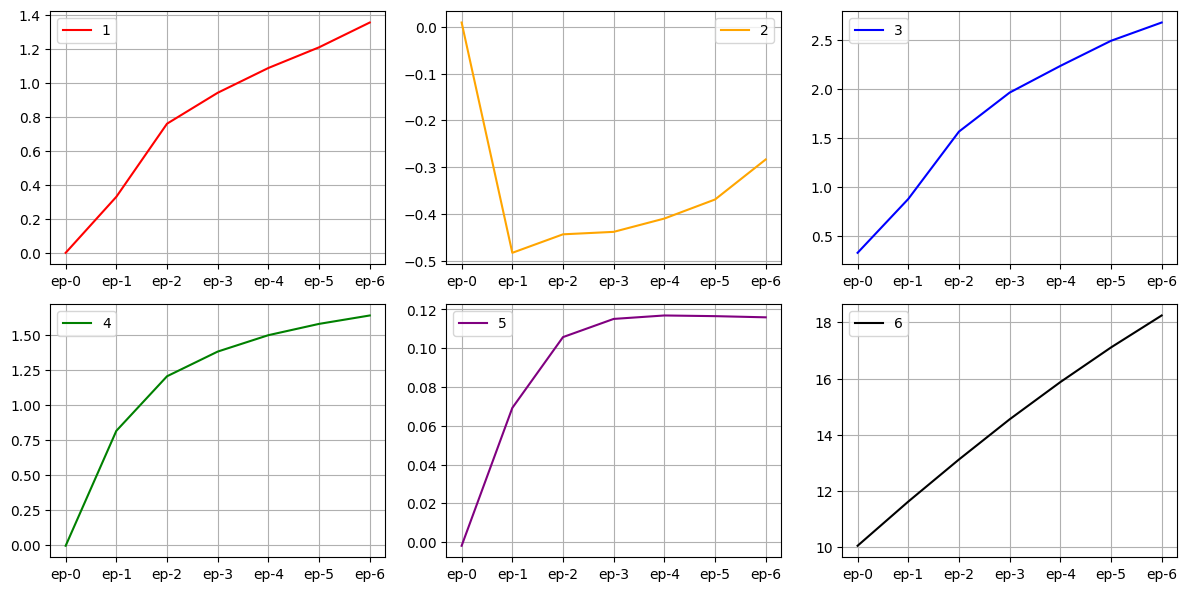

In [16]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 6))

ax1.grid(axis='both')
ax1.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_proj_1"] for v in stats_dict.values()], label = "1", color="red")
ax1.legend()

ax2.grid(axis='both')
ax2.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_noise_proj"] for v in stats_dict.values()], label = "2", color="orange")
ax2.legend()

ax3.grid(axis='both')
ax3.plot(["ep-%d"%x for x in stats_dict.keys()], [v["var_proj_1"] for v in stats_dict.values()], label = "3", color="blue")
ax3.legend()

ax4.grid(axis='both')
ax4.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_proj_2"] for v in stats_dict.values()], label = "4", color="green")
ax4.legend()

ax5.grid(axis='both')
ax5.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_sim"] for v in stats_dict.values()], label = "5", color="purple")
ax5.legend()

ax6.grid(axis='both')
ax6.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_mag"] for v in stats_dict.values()], label = "6", color="black")
ax6.legend()

fig.tight_layout()
fig.show()

# Visualize distributions

In [17]:
test_indexes = range(0, 20)

targets = [list(test_dict.keys())[test_index] for test_index in test_indexes]

print("Visuaizing for: ", targets)

Visuaizing for:  ['televised', 'uruguayan', 'credits', 'geologist', 'commerce', 'greeley', 'desperately', 'heretics', 'broadest', 'fleets', 'salvation', 'sought', 'creationist', 'oliver', 'congresses', 'odysseus', 'thumb', 'factory', 'compulsory', 'servants']


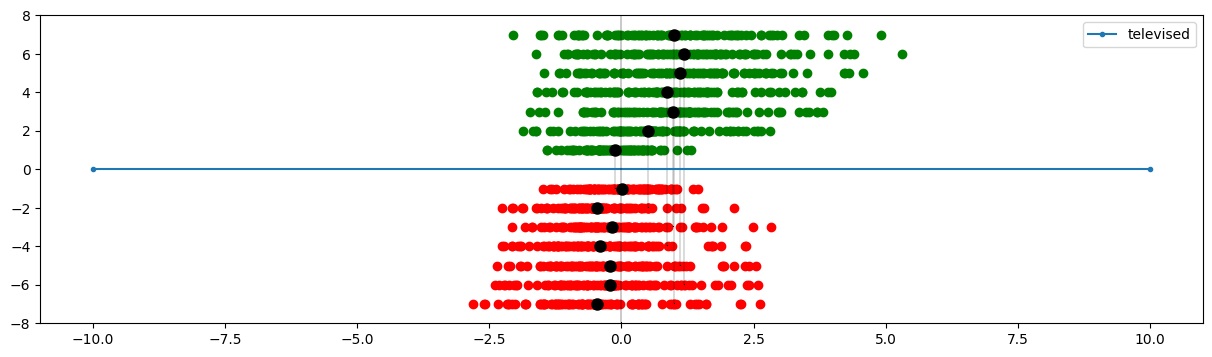

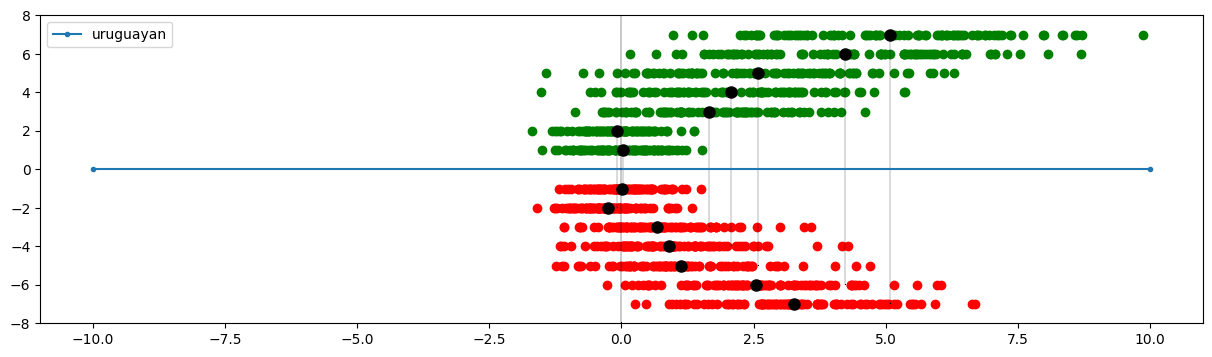

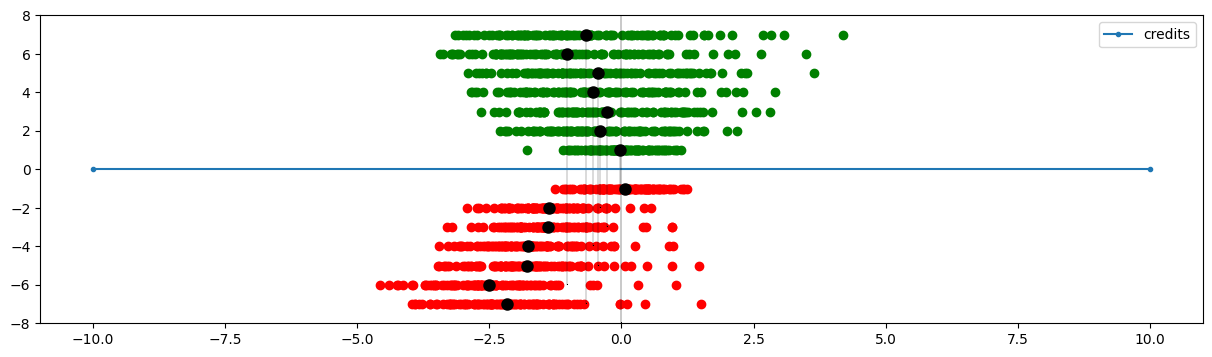

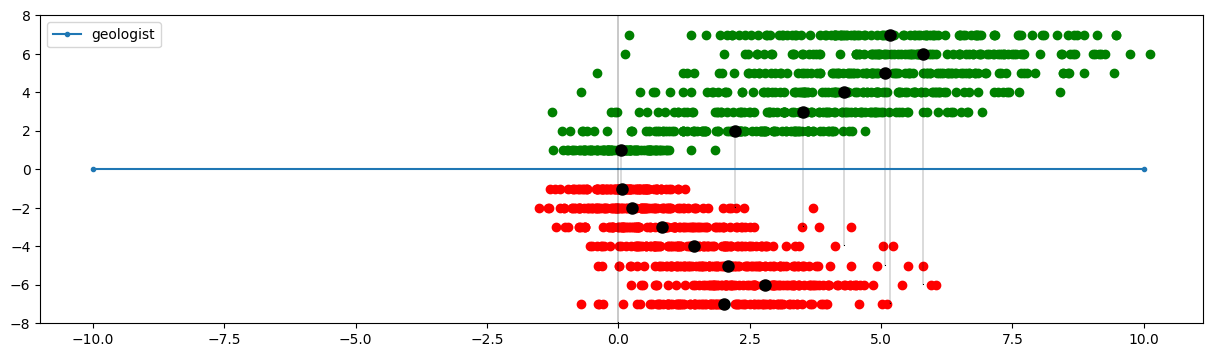

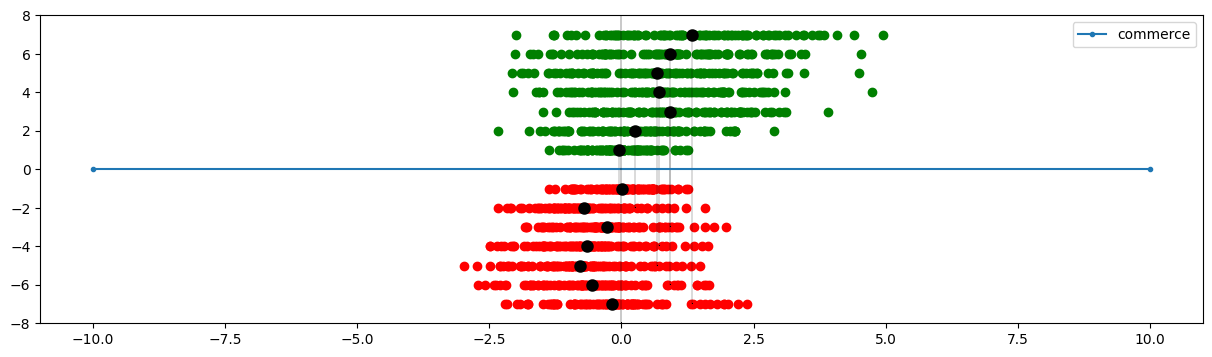

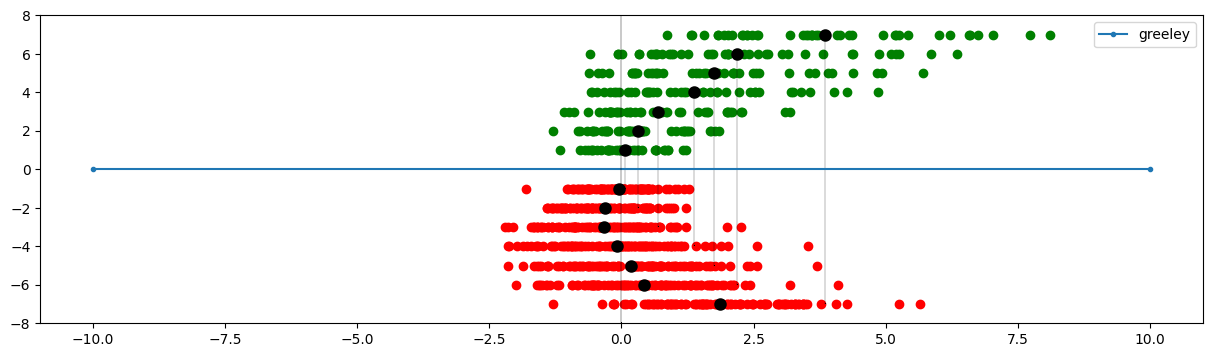

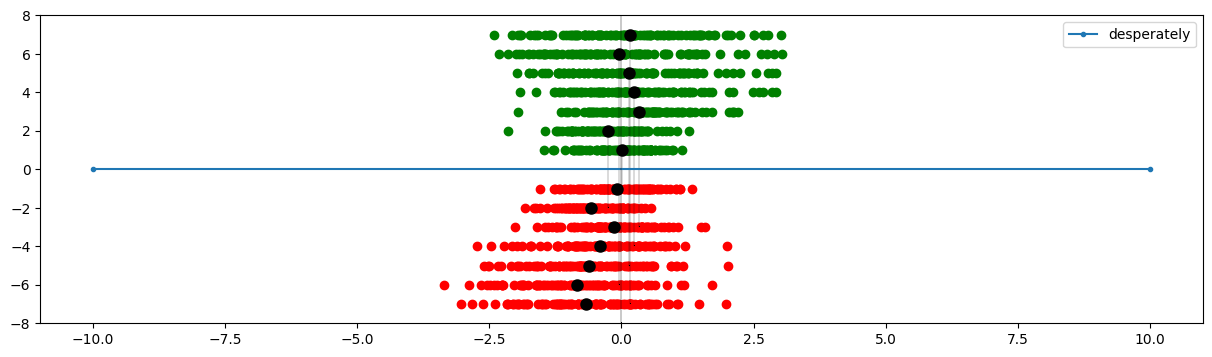

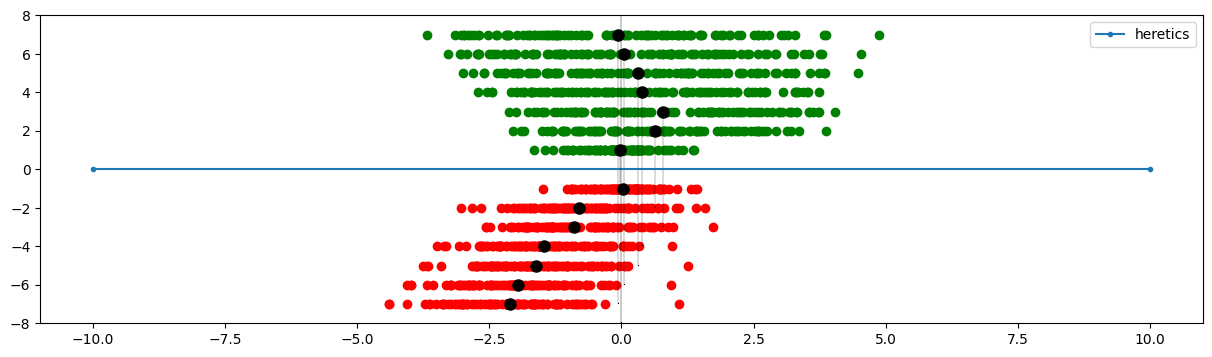

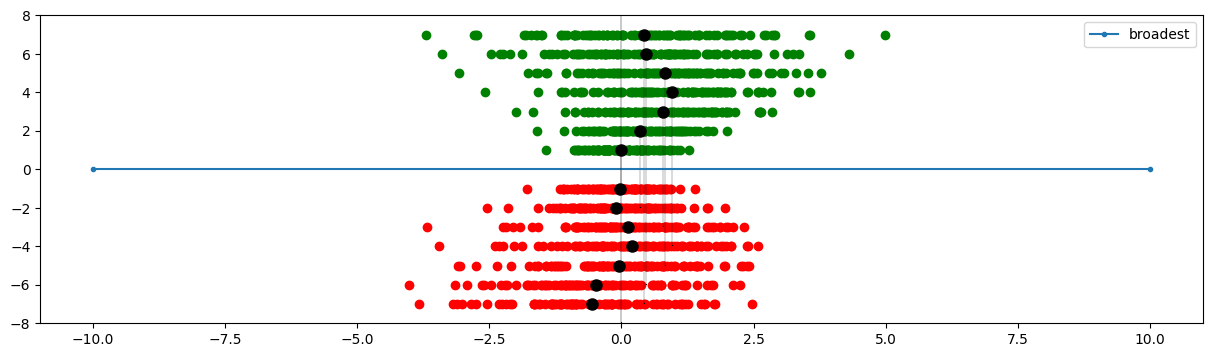

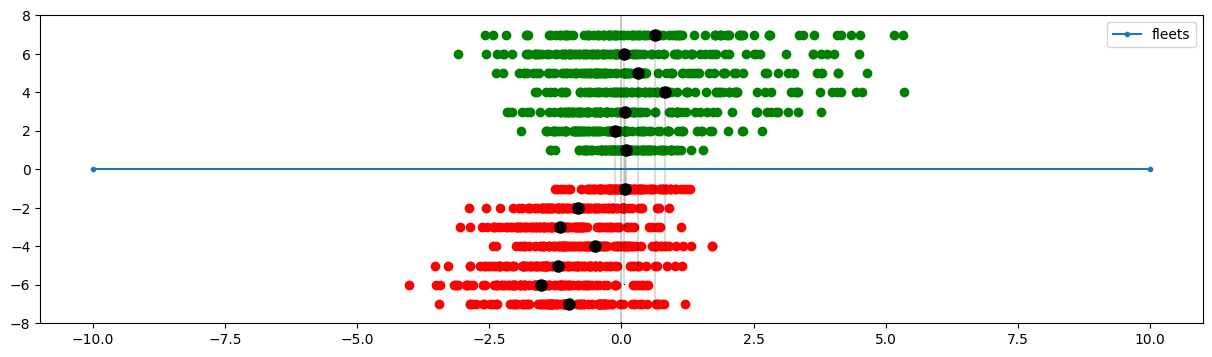

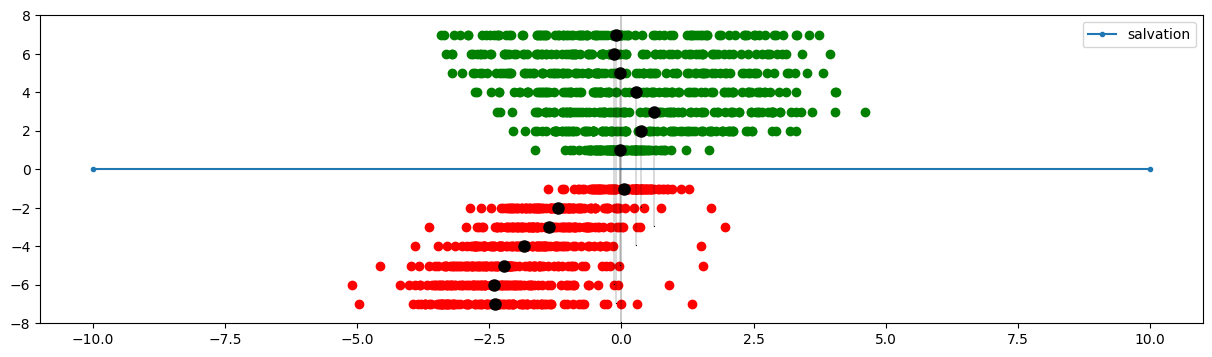

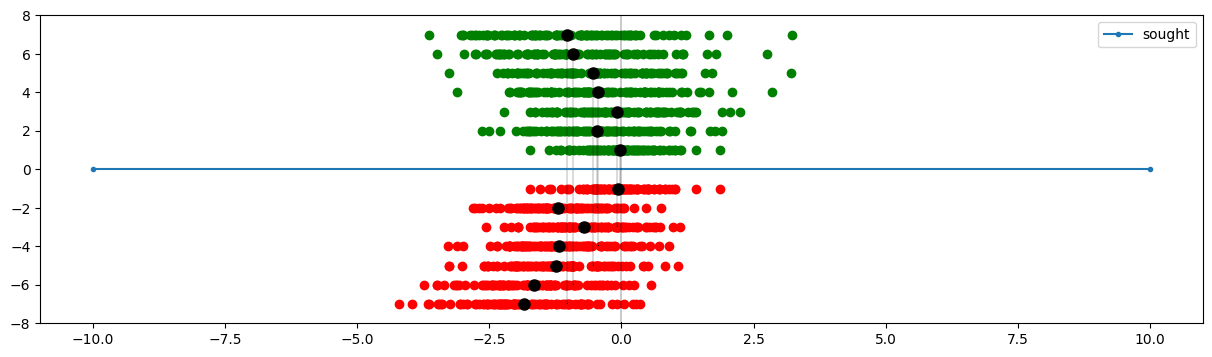

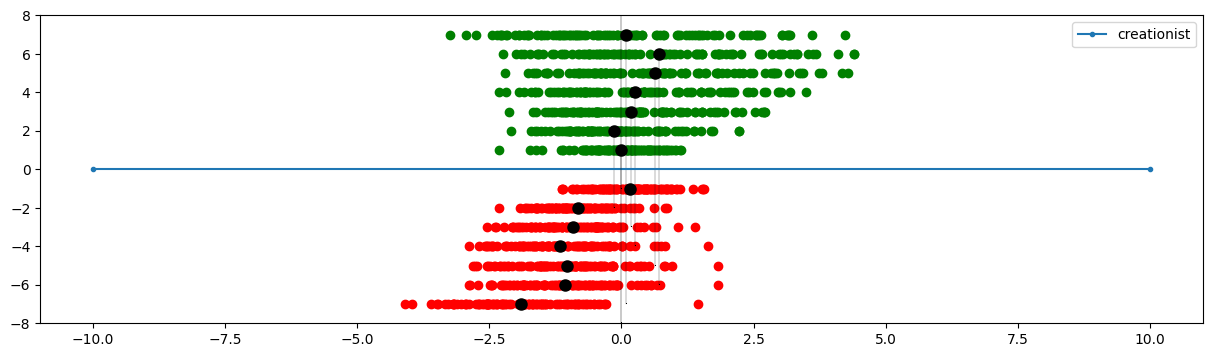

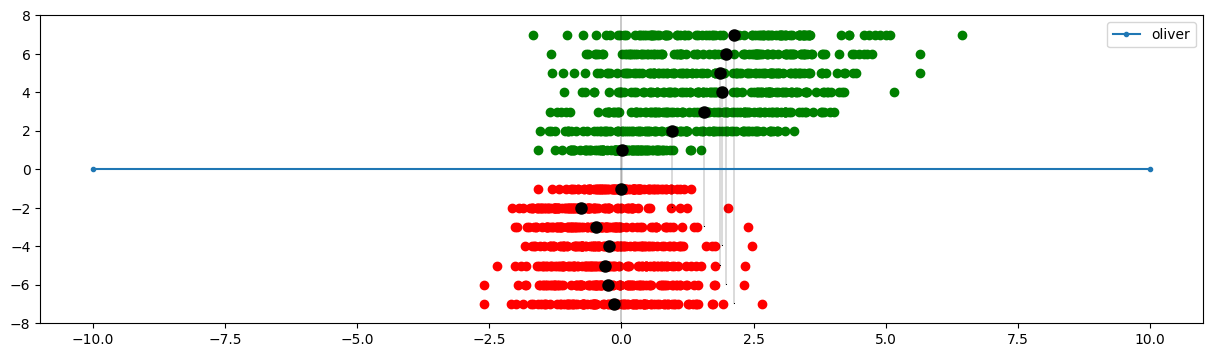

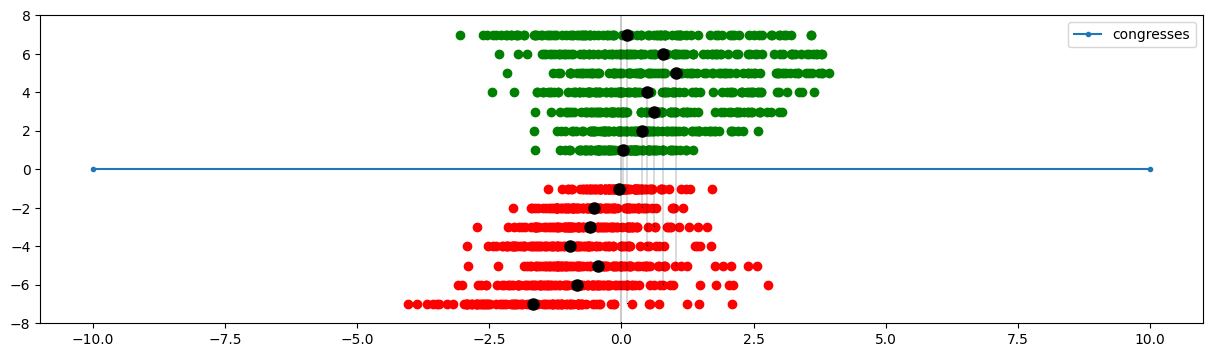

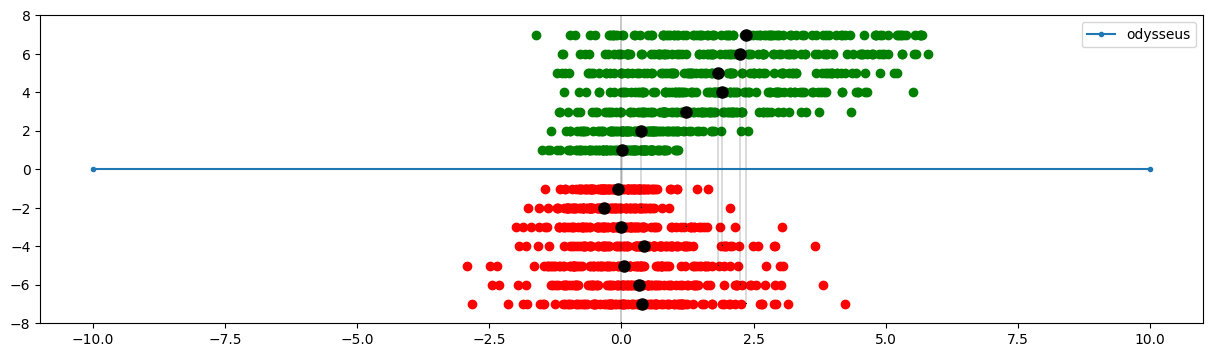

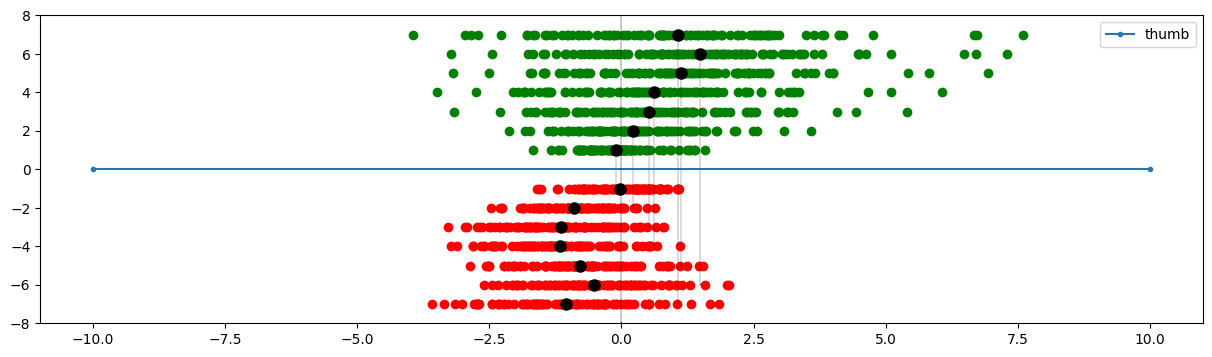

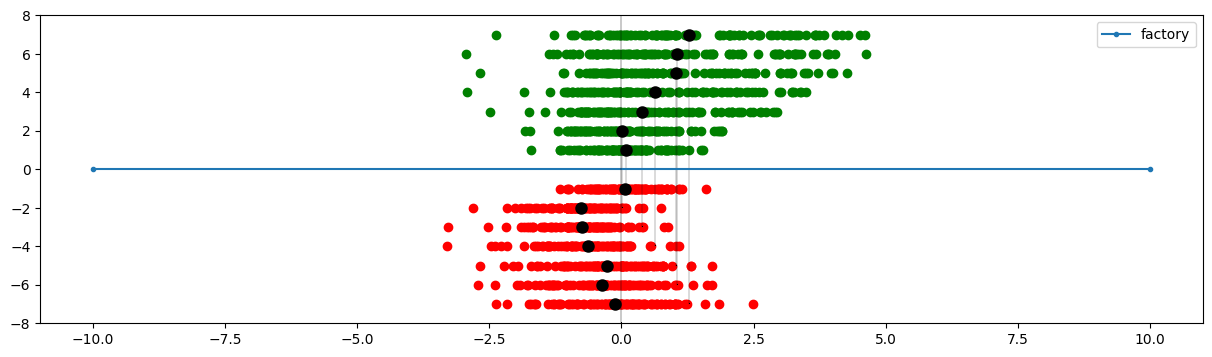

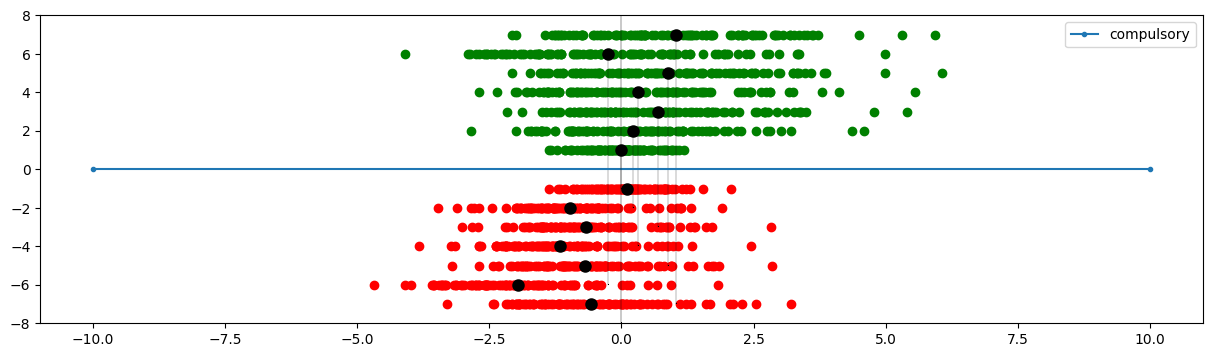

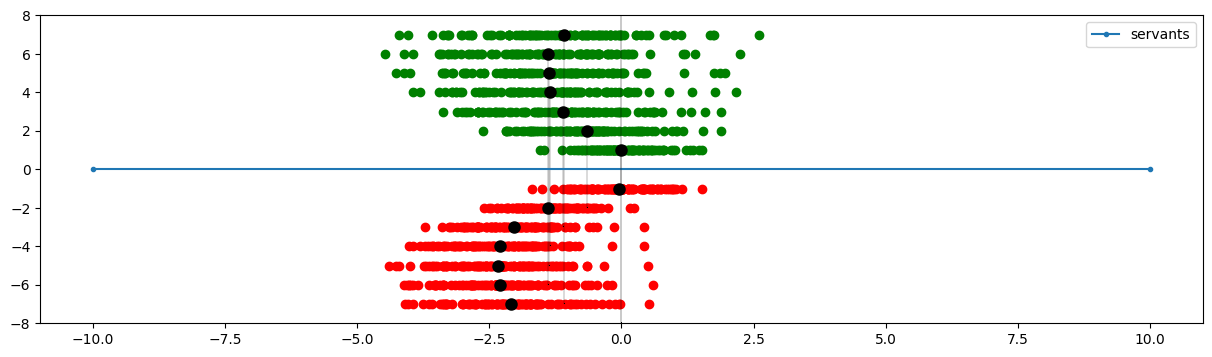

In [18]:
for trg in targets:
  contexts = test_dict[trg]["pos"]
  noises = test_dict[trg]["neg"]

  plt.figure(figsize=(15,4))

  for epoch in range(len(models1)):
    target_vectors = models1[epoch].embedding_input_dictionary()
    context_vectors = models1[epoch].embedding_output_dictionary()

    context_projections = [orthogonal_projection_position(trg, context, target_vectors, context_vectors) for context in contexts]
    noise_projections = [orthogonal_projection_position(trg, context, target_vectors, context_vectors) for context in noises]

    plt.scatter(context_projections, [epoch+1] * len(context_projections), color="green")
    plt.scatter([statistics.mean(context_projections)], [epoch+1], color="black", linewidths=3.0)
    x1, y1 = [statistics.mean(context_projections), statistics.mean(context_projections)], [-(epoch+1), (epoch+1)]
    plt.plot(x1, y1, marker = ',', color="black", linewidth=0.2)

    plt.scatter(noise_projections, [-(epoch+1)] * len(noise_projections), color="red")
    plt.scatter([statistics.mean(noise_projections)], [-(epoch+1)], color="black", linewidths=3.0)

  #magnitude = math.sqrt(sum(i**2 for i in target_vectors[trg]))
  magnitude = 10.0
  x1, y1 = [-magnitude, +magnitude], [0, 0]
  plt.plot(x1, y1, marker = '.', label=trg)

  x1, y1 = [0, 0], [-(epoch+2), (epoch+2)]
  plt.plot(x1, y1, marker = ',', color="black", linewidth=0.3)

  plt.legend()
  plt.ylim((-(epoch+2), (epoch+2)))
  plt.show()

## Clustering projections

In [19]:
cluster_dict = {model_idx: {i:0 for i in range(2,9)} for model_idx in range(len(models1))}
ideal_cluster_dict = {word:[0, 0, list()] for word in test_dict.keys()}

for model_idx in range(len(models1)):

  trg_emb = models1[model_idx].embedding_input_dictionary()
  ctx_emb = models1[model_idx].embedding_output_dictionary()
  counter = 0
  print()

  for word, samples in test_dict.items():

    contexts = samples["pos"]

    ideal_cluster_dict[word][1] = 0
    ideal_cluster_dict[word][0] = 0

    for k in range(2,9):

      score, cluster_indices = kmeans_cluster(k, [orthogonal_projection_position(word, ctx, trg_emb, ctx_emb) for ctx in contexts])
      #clusters = [[contexts[idx] for idx in cluster] for cluster in cluster_indices.values()]

      cluster_dict[model_idx][k] = cluster_dict[model_idx][k] + (score / len(test_dict.items()))

      if ideal_cluster_dict[word][1] < score:
        ideal_cluster_dict[word][1] = score
        ideal_cluster_dict[word][0] = k
    ideal_cluster_dict[word][2].append((ideal_cluster_dict[word][0], ideal_cluster_dict[word][1]))

    counter += 1
    print("\r[MODEL #%d] Progress: %d/%d" % (model_idx, counter, len(test_dict.items())), end='')

  print("\n", cluster_dict[model_idx])


[MODEL #0] Progress: 50/50
 {2: 0.5608897394733822, 3: 0.5505068078618469, 4: 0.5495129883785328, 5: 0.5516921106847872, 6: 0.5523347650927377, 7: 0.5560199763982042, 8: 0.5613784376866041}

[MODEL #1] Progress: 50/50
 {2: 0.5790743876190663, 3: 0.5577862931400667, 4: 0.5550268085401914, 5: 0.554234556239334, 6: 0.5522437202173623, 7: 0.5578125462436695, 8: 0.564128087715723}

[MODEL #2] Progress: 50/50
 {2: 0.5942820809392434, 3: 0.5645891857528332, 4: 0.5506155483751903, 5: 0.5512824811119196, 6: 0.5490134750462354, 7: 0.5566842617721959, 8: 0.558649654904305}

[MODEL #3] Progress: 50/50
 {2: 0.5953783469234013, 3: 0.5508989530365703, 4: 0.5549147117835226, 5: 0.5483093378245167, 6: 0.5523735040488578, 7: 0.5547469251732337, 8: 0.5628052625759932}

[MODEL #4] Progress: 50/50
 {2: 0.5951365083157275, 3: 0.5583590640036561, 4: 0.5552103646964522, 5: 0.5542258308426127, 6: 0.5553163754661394, 7: 0.5531411722161074, 8: 0.5560028263665503}

[MODEL #5] Progress: 50/50
 {2: 0.5918581915056

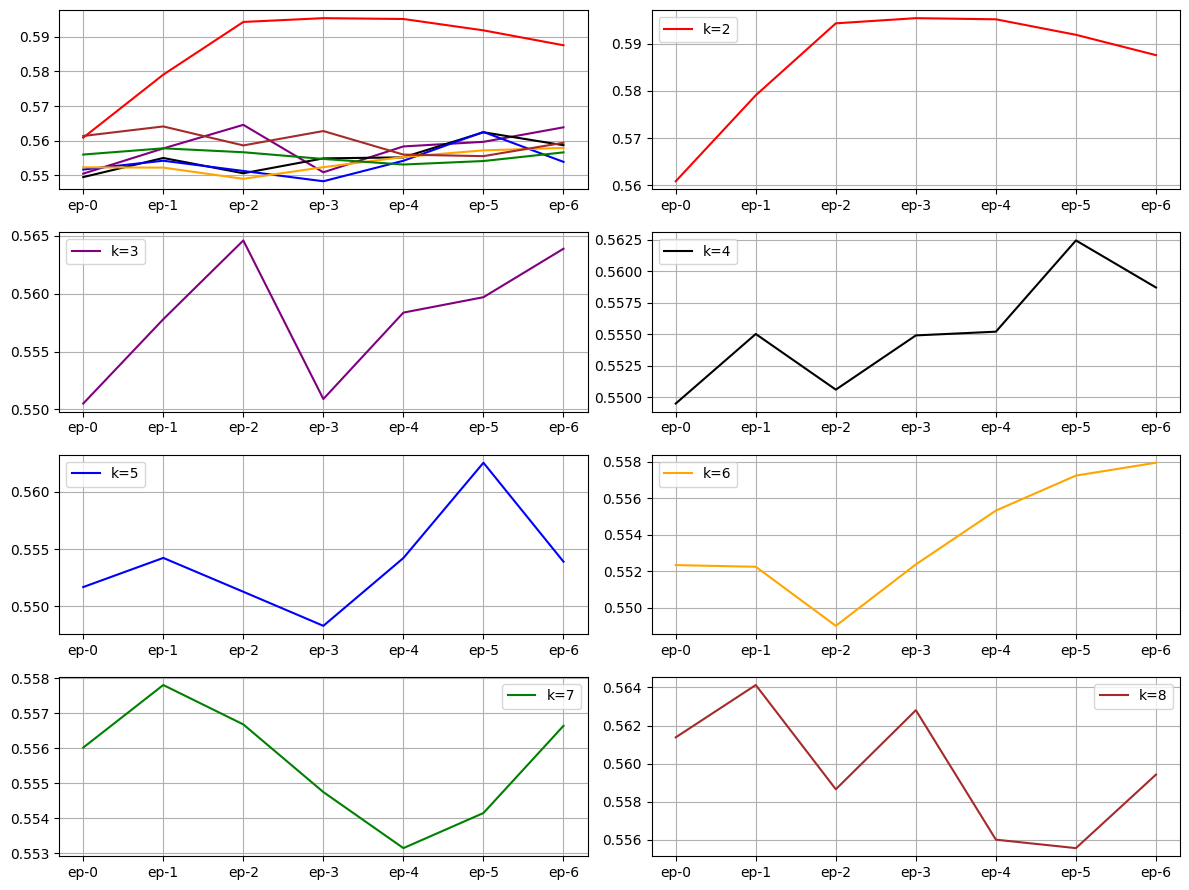

In [20]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(nrows = 4, ncols = 2, figsize = (12, 9))

ax1.grid(axis='both')
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[2] for v in cluster_dict.values()], label = "k=2", color="red")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[3] for v in cluster_dict.values()], label = "k=3", color="purple")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[4] for v in cluster_dict.values()], label = "k=4", color="black")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[5] for v in cluster_dict.values()], label = "k=5", color="blue")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[6] for v in cluster_dict.values()], label = "k=6", color="orange")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[7] for v in cluster_dict.values()], label = "k=7", color="green")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[8] for v in cluster_dict.values()], label = "k=8", color="brown")

ax2.grid(axis='both')
ax2.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[2] for v in cluster_dict.values()], label = "k=2", color="red")
ax2.legend()

ax3.grid(axis='both')
ax3.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[3] for v in cluster_dict.values()], label = "k=3", color="purple")
ax3.legend()

ax4.grid(axis='both')
ax4.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[4] for v in cluster_dict.values()], label = "k=4", color="black")
ax4.legend()

ax5.grid(axis='both')
ax5.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[5] for v in cluster_dict.values()], label = "k=5", color="blue")
ax5.legend()

ax6.grid(axis='both')
ax6.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[6] for v in cluster_dict.values()], label = "k=6", color="orange")
ax6.legend()

ax7.grid(axis='both')
ax7.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[7] for v in cluster_dict.values()], label = "k=7", color="green")
ax7.legend()

ax8.grid(axis='both')
ax8.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[8] for v in cluster_dict.values()], label = "k=8", color="brown")
ax8.legend()


fig.tight_layout()
fig.show()

In [21]:
cluster_table = PrettyTable()
cluster_table.field_names = ["Target", "Ideal Nr of Clusters per Epoch", "Score"]
for word in test_dict.keys():
  cluster_table.add_row([word, [x[0] for x in ideal_cluster_dict[word][2]], ["%.3f"%x[1] for x in ideal_cluster_dict[word][2]]])

print(cluster_table)

+---------------+--------------------------------+-----------------------------------------------------------------+
|     Target    | Ideal Nr of Clusters per Epoch |                              Score                              |
+---------------+--------------------------------+-----------------------------------------------------------------+
|   televised   |     [6, 6, 3, 3, 6, 7, 6]      | ['0.559', '0.633', '0.605', '0.585', '0.570', '0.563', '0.561'] |
|   uruguayan   |     [2, 5, 2, 2, 2, 2, 2]      | ['0.578', '0.559', '0.616', '0.612', '0.611', '0.612', '0.610'] |
|    credits    |     [3, 2, 2, 2, 2, 2, 2]      | ['0.556', '0.630', '0.607', '0.587', '0.605', '0.622', '0.613'] |
|   geologist   |     [6, 7, 6, 2, 2, 4, 8]      | ['0.596', '0.602', '0.547', '0.559', '0.572', '0.621', '0.587'] |
|    commerce   |     [7, 8, 2, 8, 3, 5, 6]      | ['0.592', '0.609', '0.610', '0.580', '0.582', '0.633', '0.560'] |
|    greeley    |     [8, 4, 8, 2, 3, 3, 8]      | ['0.656', '0.

# v15

In [22]:
models2 = models[1]

## Stats

In [23]:
stats_table, stats_dict = get_stats(models2, test_dict)


[MODEL #0] Progress: 50/50
[MODEL #1] Progress: 50/50
[MODEL #2] Progress: 50/50
[MODEL #3] Progress: 50/50
[MODEL #4] Progress: 50/50
[MODEL #5] Progress: 50/50
[MODEL #6] Progress: 50/50

### Stats Dictionary
1. Average context (ctx repr.) projections on target (trg repr.)
2. Average noise (ctx repr.) projections on target (trg repr.)
3. Average ***variance*** of context (ctx repr.) projections on target (trg repr.)
4. Average projection **difference** of context (ctx repr.) and noise (ctx repr.) on target (trg repr.)
5. Average ***cos-similarity*** of context (trg repr.) and target (trg repr.)
6. Average target magnitude

In [24]:
print(stats_table)

+---------------+--------+--------+-------+-------+-------+--------+
|     Target    |   1    |   2    |   3   |   4   |   5   |   6    |
+---------------+--------+--------+-------+-------+-------+--------+
|   televised   | 0.623  | -1.134 | 2.724 | 1.756 | 0.151 | 19.819 |
|   uruguayan   | 3.715  | 1.626  | 3.713 | 2.089 | 0.167 | 15.057 |
|    credits    | -3.740 | -5.291 | 2.647 | 1.551 | 0.098 | 20.367 |
|   geologist   | 6.636  | 2.837  | 5.720 | 3.799 | 0.302 | 18.587 |
|    commerce   | 0.454  | -1.067 | 2.338 | 1.521 | 0.138 | 21.066 |
|    greeley    | 1.243  | -0.482 | 2.956 | 1.725 | 0.125 | 13.138 |
|  desperately  | -0.009 | -0.693 | 1.303 | 0.684 | 0.044 | 17.987 |
|    heretics   | -1.204 | -3.519 | 4.372 | 2.316 | 0.205 | 18.810 |
|    broadest   | -0.101 | -0.950 | 1.498 | 0.849 | 0.074 | 18.524 |
|     fleets    | 0.507  | -0.904 | 3.569 | 1.411 | 0.126 | 18.847 |
|   salvation   | -2.086 | -4.979 | 5.852 | 2.893 | 0.233 | 19.229 |
|     sought    | -1.988 | -2.949 

In [25]:
for model_idx, values in stats_dict.items():
  print("EPOCH #%d [1: %.3f] [2: %.3f] [3: %.3f] [4: %.3f] [5: %.3f] [6: %.3f] " % (model_idx, values["avg_proj_1"], values["avg_noise_proj"], values["var_proj_1"], values["avg_proj_2"], values["avg_sim"], values["avg_mag"]))

EPOCH #0 [1: 0.002] [2: 0.009] [3: 0.332] [4: -0.008] [5: -0.002] [6: 10.047] 
EPOCH #1 [1: 0.217] [2: -0.688] [3: 1.078] [4: 0.905] [5: 0.077] [6: 11.610] 
EPOCH #2 [1: 0.565] [2: -0.854] [3: 2.090] [4: 1.419] [5: 0.127] [6: 13.166] 
EPOCH #3 [1: 0.719] [2: -0.900] [3: 2.566] [4: 1.618] [5: 0.140] [6: 14.606] 
EPOCH #4 [1: 0.852] [2: -0.879] [3: 2.859] [4: 1.731] [5: 0.145] [6: 15.953] 
EPOCH #5 [1: 0.930] [2: -0.879] [3: 3.092] [4: 1.808] [5: 0.144] [6: 17.240] 
EPOCH #6 [1: 0.922] [2: -0.934] [3: 3.248] [4: 1.856] [5: 0.142] [6: 18.490] 


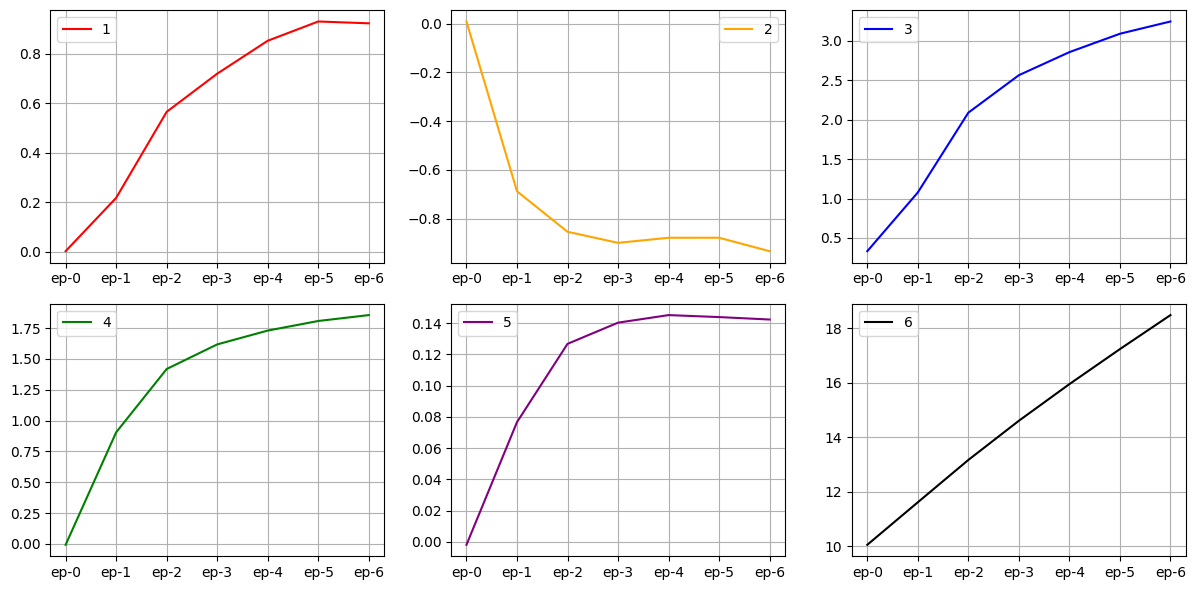

In [26]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 6))

ax1.grid(axis='both')
ax1.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_proj_1"] for v in stats_dict.values()], label = "1", color="red")
ax1.legend()

ax2.grid(axis='both')
ax2.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_noise_proj"] for v in stats_dict.values()], label = "2", color="orange")
ax2.legend()

ax3.grid(axis='both')
ax3.plot(["ep-%d"%x for x in stats_dict.keys()], [v["var_proj_1"] for v in stats_dict.values()], label = "3", color="blue")
ax3.legend()

ax4.grid(axis='both')
ax4.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_proj_2"] for v in stats_dict.values()], label = "4", color="green")
ax4.legend()

ax5.grid(axis='both')
ax5.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_sim"] for v in stats_dict.values()], label = "5", color="purple")
ax5.legend()

ax6.grid(axis='both')
ax6.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_mag"] for v in stats_dict.values()], label = "6", color="black")
ax6.legend()

fig.tight_layout()
fig.show()

# Visualize distributions

In [27]:
test_indexes = range(0, 20)

targets = [list(test_dict.keys())[test_index] for test_index in test_indexes]

print("Visuaizing for: ", targets)

Visuaizing for:  ['televised', 'uruguayan', 'credits', 'geologist', 'commerce', 'greeley', 'desperately', 'heretics', 'broadest', 'fleets', 'salvation', 'sought', 'creationist', 'oliver', 'congresses', 'odysseus', 'thumb', 'factory', 'compulsory', 'servants']


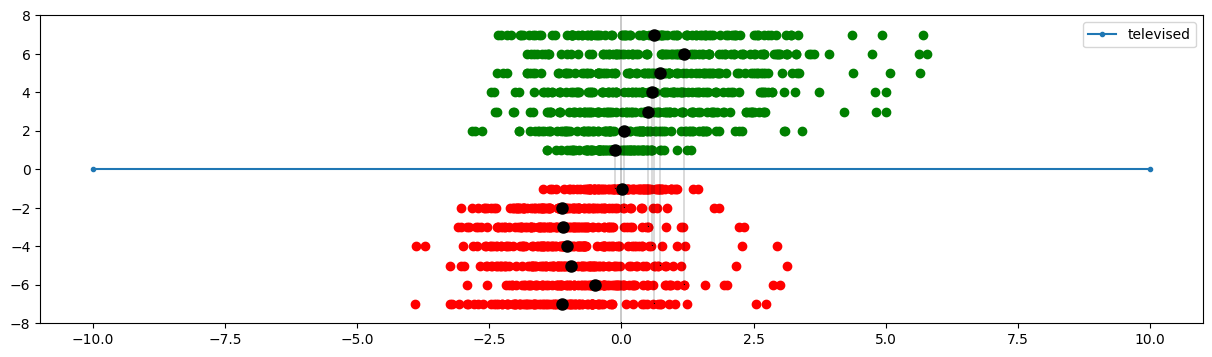

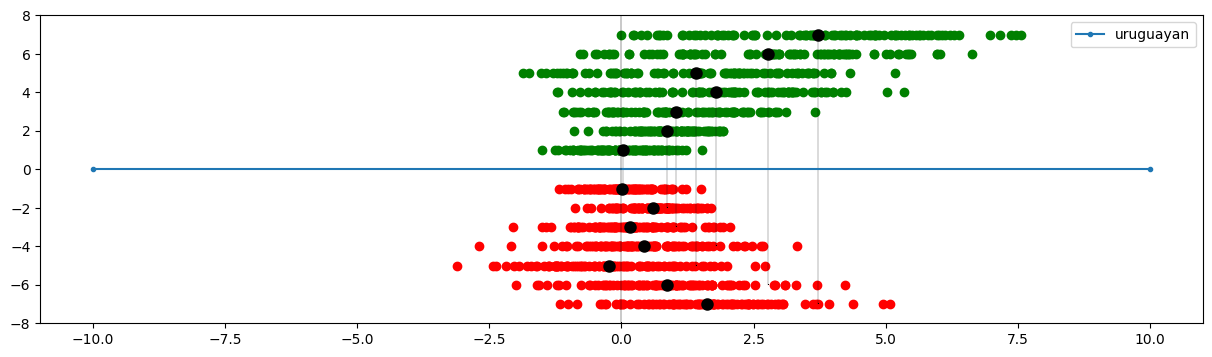

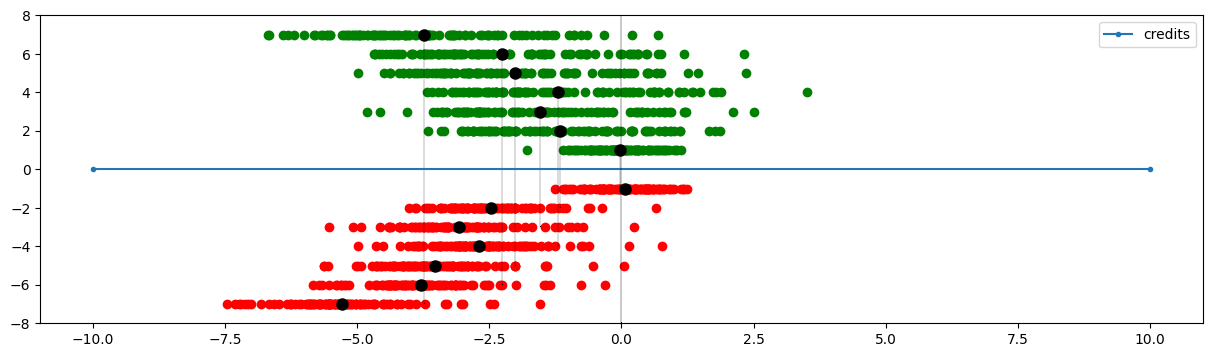

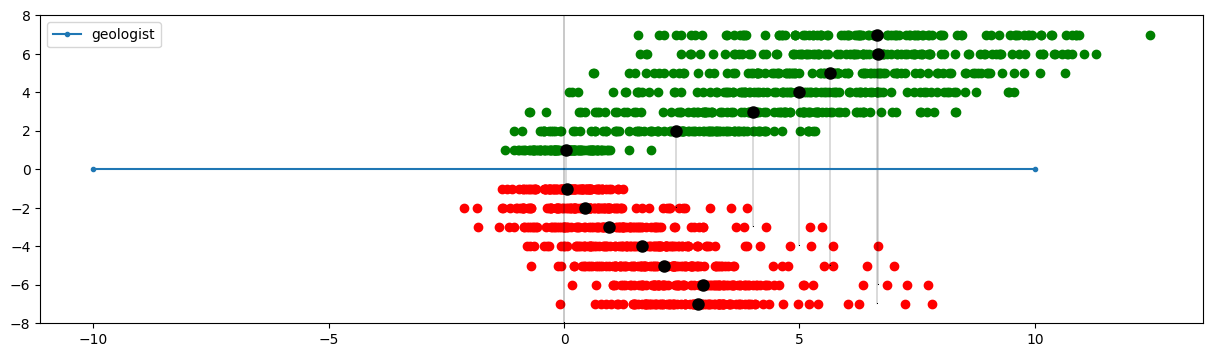

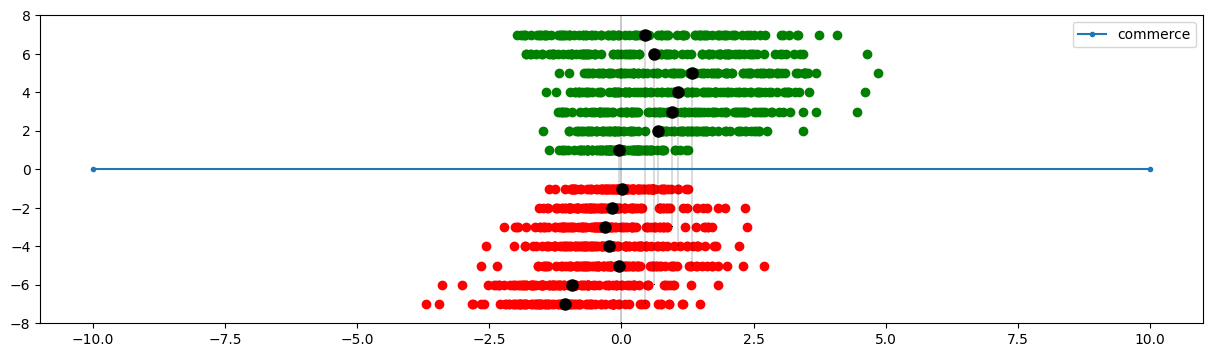

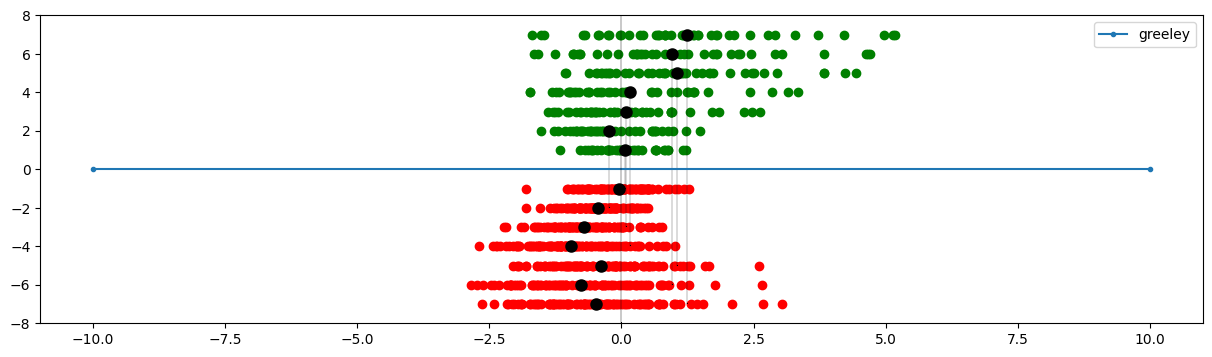

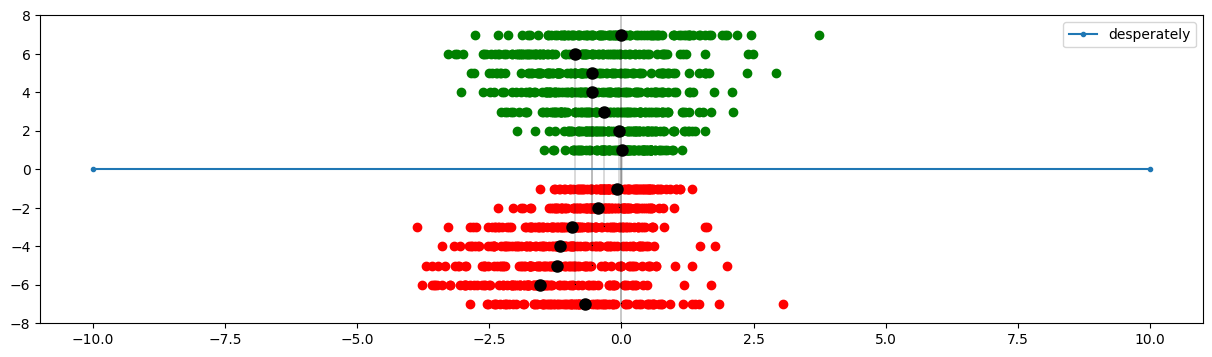

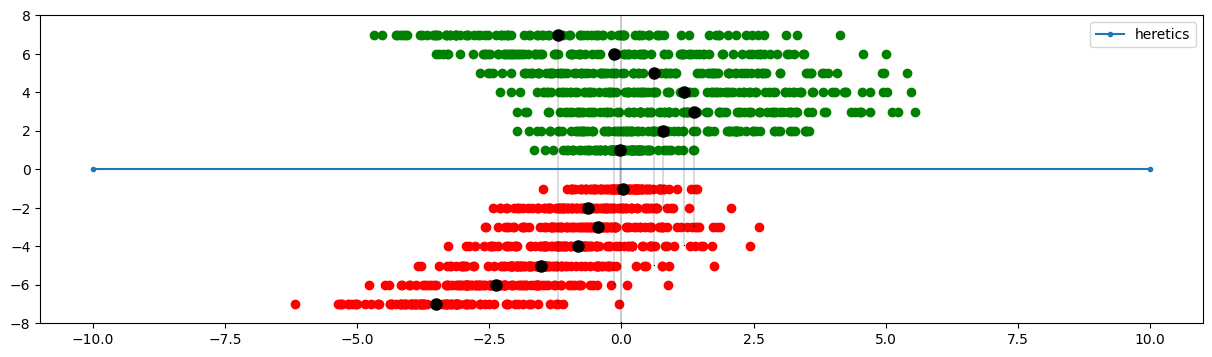

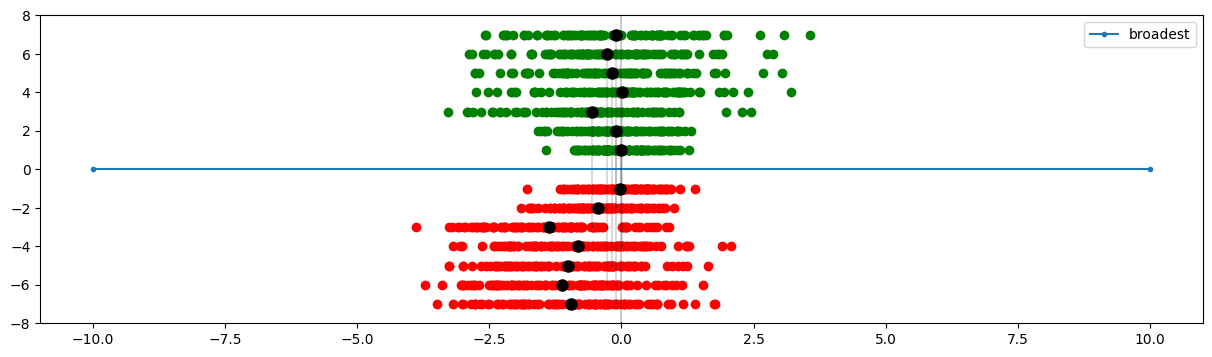

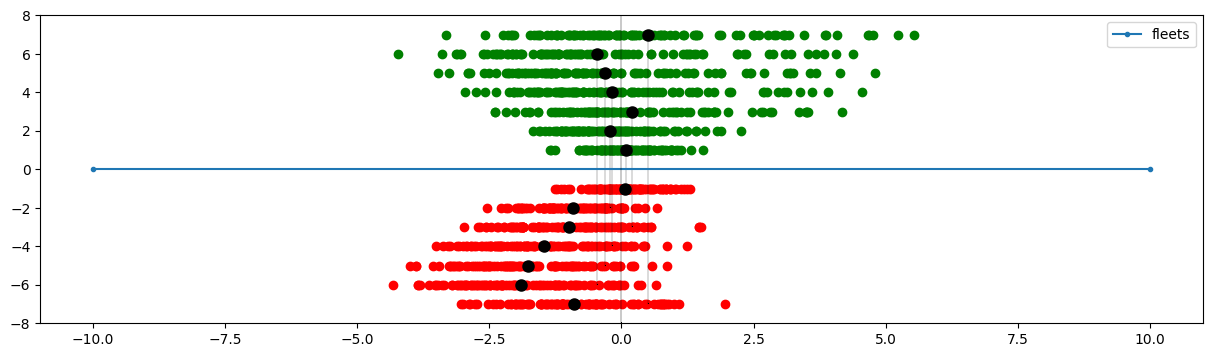

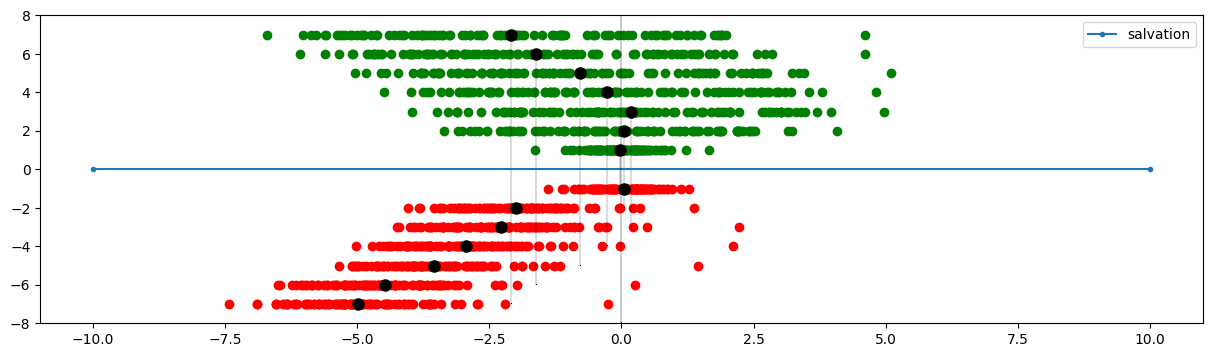

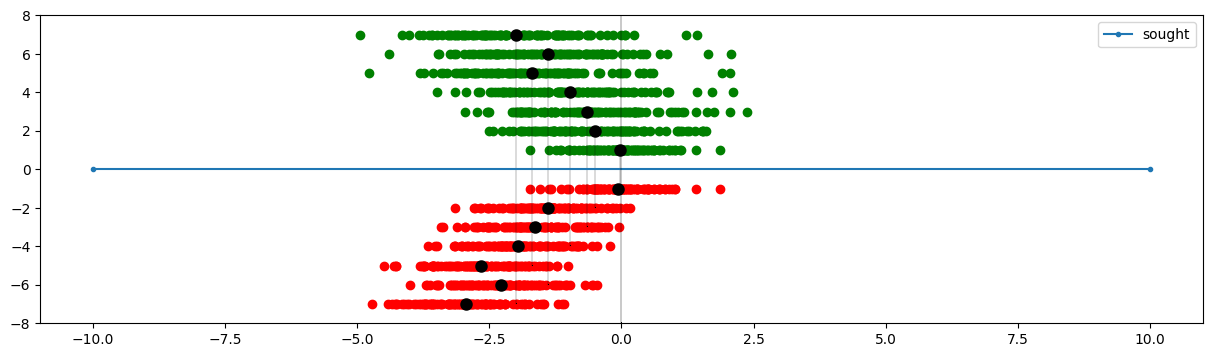

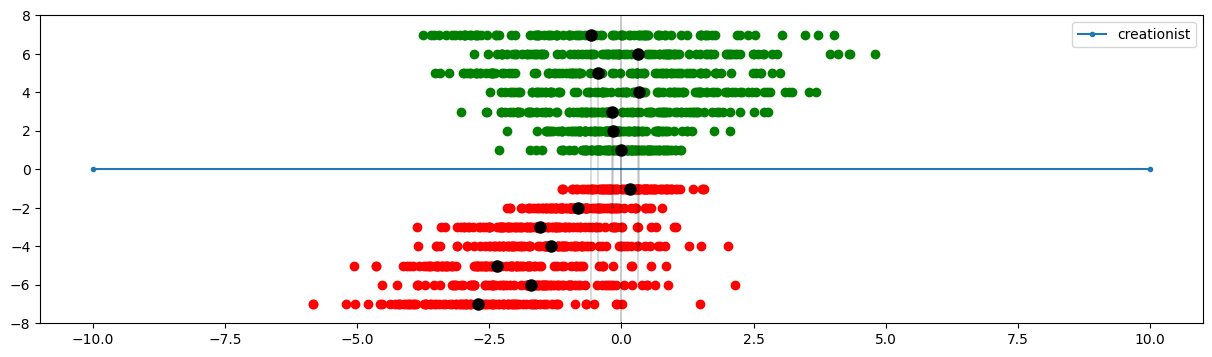

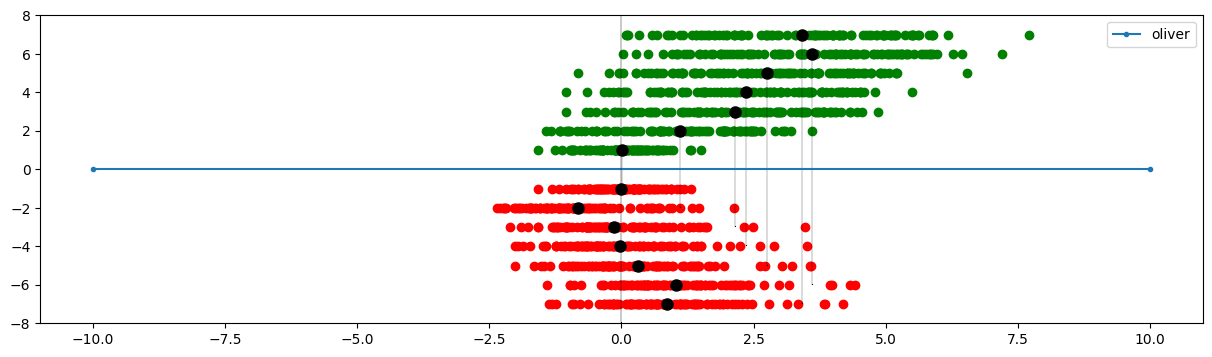

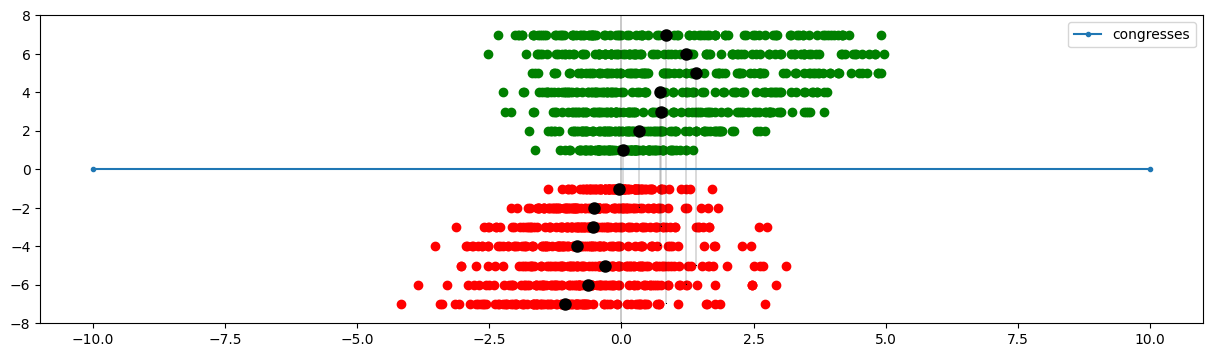

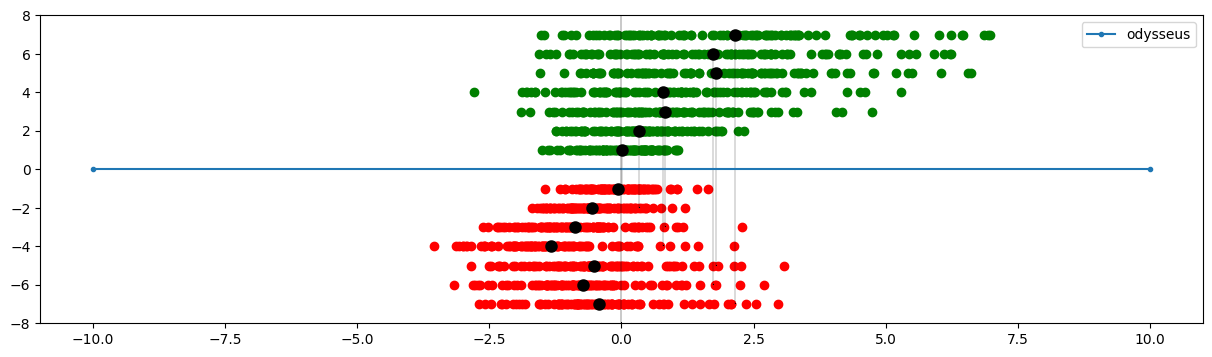

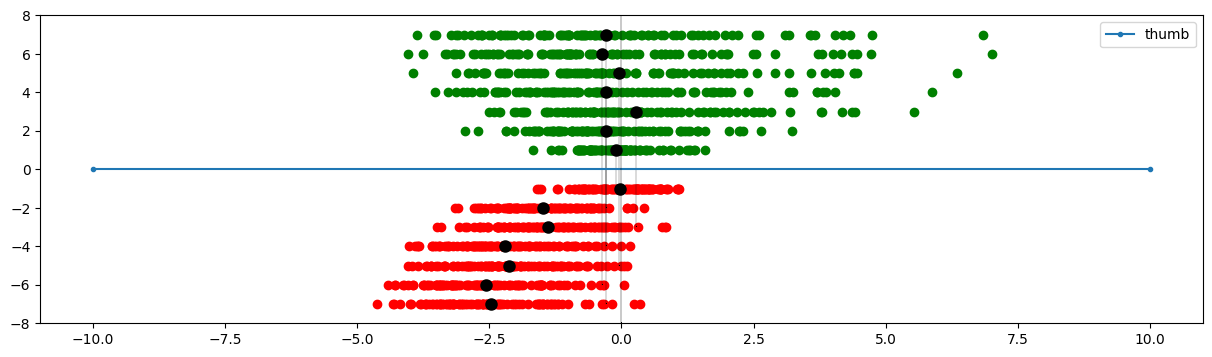

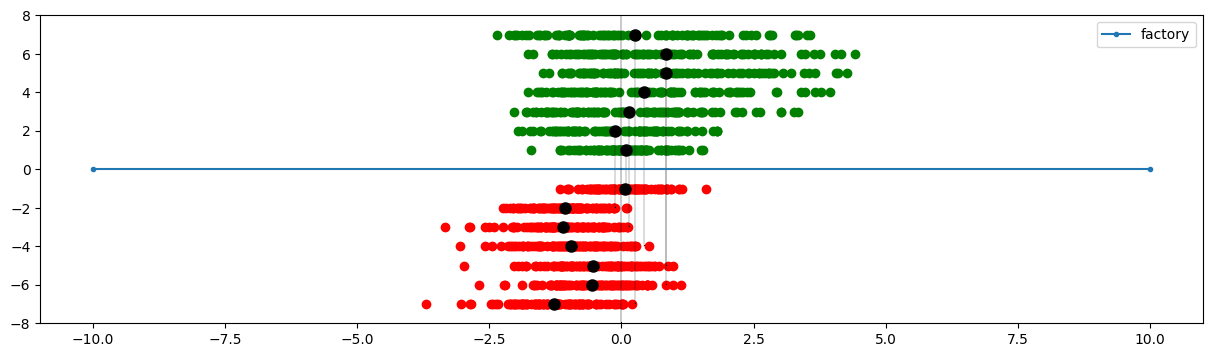

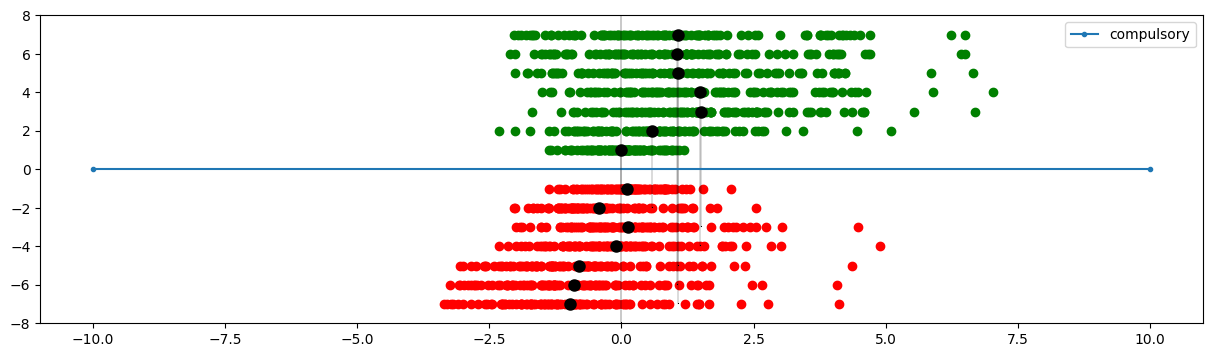

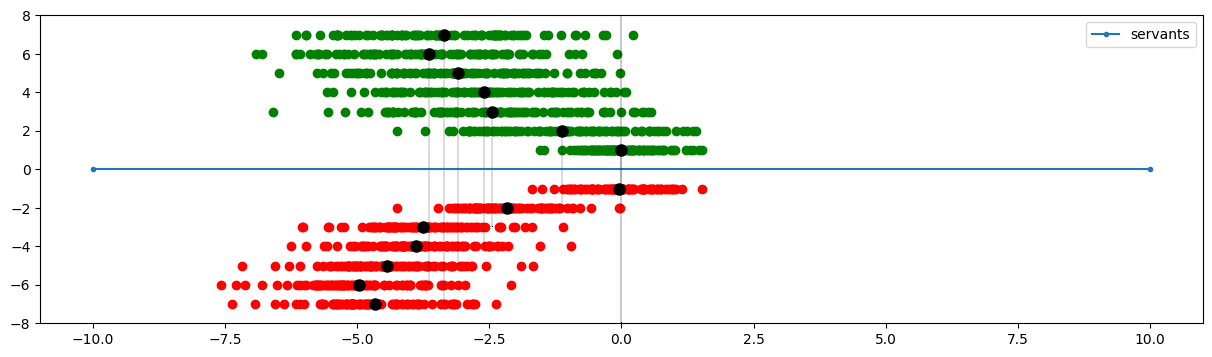

In [28]:
for trg in targets:
  contexts = test_dict[trg]["pos"]
  noises = test_dict[trg]["neg"]

  plt.figure(figsize=(15,4))

  for epoch in range(len(models2)):
    target_vectors = models2[epoch].embedding_input_dictionary()
    context_vectors = models2[epoch].embedding_output_dictionary()

    context_projections = [orthogonal_projection_position(trg, context, target_vectors, context_vectors) for context in contexts]
    noise_projections = [orthogonal_projection_position(trg, context, target_vectors, context_vectors) for context in noises]

    plt.scatter(context_projections, [epoch+1] * len(context_projections), color="green")
    plt.scatter([statistics.mean(context_projections)], [epoch+1], color="black", linewidths=3.0)
    x1, y1 = [statistics.mean(context_projections), statistics.mean(context_projections)], [-(epoch+1), (epoch+1)]
    plt.plot(x1, y1, marker = ',', color="black", linewidth=0.2)

    plt.scatter(noise_projections, [-(epoch+1)] * len(noise_projections), color="red")
    plt.scatter([statistics.mean(noise_projections)], [-(epoch+1)], color="black", linewidths=3.0)

  #magnitude = math.sqrt(sum(i**2 for i in target_vectors[trg]))
  magnitude = 10.0
  x1, y1 = [-magnitude, +magnitude], [0, 0]
  plt.plot(x1, y1, marker = '.', label=trg)

  x1, y1 = [0, 0], [-(epoch+2), (epoch+2)]
  plt.plot(x1, y1, marker = ',', color="black", linewidth=0.3)

  plt.legend()
  plt.ylim((-(epoch+2), (epoch+2)))
  plt.show()

## Clustering projections

In [29]:
cluster_dict = {model_idx: {i:0 for i in range(2,9)} for model_idx in range(len(models2))}
ideal_cluster_dict = {word:[0, 0, list()] for word in test_dict.keys()}

for model_idx in range(len(models2)):

  trg_emb = models2[model_idx].embedding_input_dictionary()
  ctx_emb = models2[model_idx].embedding_output_dictionary()
  counter = 0
  print()

  for word, samples in test_dict.items():

    contexts = samples["pos"]

    ideal_cluster_dict[word][1] = 0
    ideal_cluster_dict[word][0] = 0

    for k in range(2,9):

      score, cluster_indices = kmeans_cluster(k, [orthogonal_projection_position(word, ctx, trg_emb, ctx_emb) for ctx in contexts])
      #clusters = [[contexts[idx] for idx in cluster] for cluster in cluster_indices.values()]

      cluster_dict[model_idx][k] = cluster_dict[model_idx][k] + (score / len(test_dict.items()))

      if ideal_cluster_dict[word][1] < score:
        ideal_cluster_dict[word][1] = score
        ideal_cluster_dict[word][0] = k
    ideal_cluster_dict[word][2].append((ideal_cluster_dict[word][0], ideal_cluster_dict[word][1]))

    counter += 1
    print("\r[MODEL #%d] Progress: %d/%d" % (model_idx, counter, len(test_dict.items())), end='')

  print("\n", cluster_dict[model_idx])


[MODEL #0] Progress: 50/50
 {2: 0.5608897394733822, 3: 0.5505068078618469, 4: 0.5495129883785328, 5: 0.5516921106847872, 6: 0.5523347650927377, 7: 0.5560199763982042, 8: 0.5613784376866041}

[MODEL #1] Progress: 50/50
 {2: 0.5806395663945629, 3: 0.568237728797688, 4: 0.5614878265334303, 5: 0.5570098053886443, 6: 0.5521037932657439, 7: 0.5570989140072322, 8: 0.5591901632639262}

[MODEL #2] Progress: 50/50
 {2: 0.5874866652353871, 3: 0.5658219059332448, 4: 0.5512002382194706, 5: 0.553053736706792, 6: 0.5550836394817399, 7: 0.5528096722027626, 8: 0.5581763667583065}

[MODEL #3] Progress: 50/50
 {2: 0.5931695642228824, 3: 0.5601597651899204, 4: 0.5564178108048166, 5: 0.5505887003841388, 6: 0.5474513142420414, 7: 0.5485512788903892, 8: 0.5585919318551921}

[MODEL #4] Progress: 50/50
 {2: 0.5914657467126386, 3: 0.5592725471110557, 4: 0.5549068604898522, 5: 0.5501328639777091, 6: 0.5438820767918932, 7: 0.5481346270637503, 8: 0.5531679080694948}

[MODEL #5] Progress: 50/50
 {2: 0.592417318315

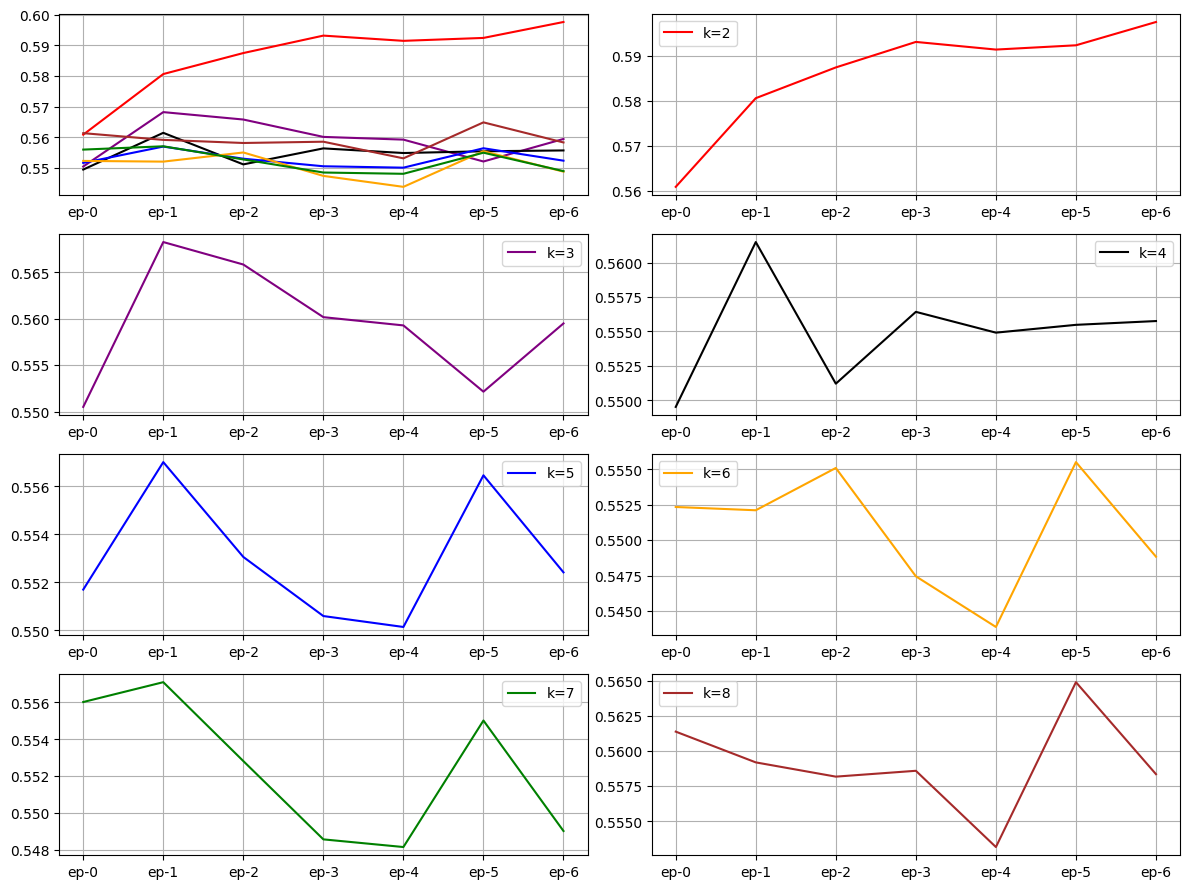

In [30]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(nrows = 4, ncols = 2, figsize = (12, 9))

ax1.grid(axis='both')
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[2] for v in cluster_dict.values()], label = "k=2", color="red")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[3] for v in cluster_dict.values()], label = "k=3", color="purple")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[4] for v in cluster_dict.values()], label = "k=4", color="black")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[5] for v in cluster_dict.values()], label = "k=5", color="blue")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[6] for v in cluster_dict.values()], label = "k=6", color="orange")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[7] for v in cluster_dict.values()], label = "k=7", color="green")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[8] for v in cluster_dict.values()], label = "k=8", color="brown")

ax2.grid(axis='both')
ax2.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[2] for v in cluster_dict.values()], label = "k=2", color="red")
ax2.legend()

ax3.grid(axis='both')
ax3.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[3] for v in cluster_dict.values()], label = "k=3", color="purple")
ax3.legend()

ax4.grid(axis='both')
ax4.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[4] for v in cluster_dict.values()], label = "k=4", color="black")
ax4.legend()

ax5.grid(axis='both')
ax5.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[5] for v in cluster_dict.values()], label = "k=5", color="blue")
ax5.legend()

ax6.grid(axis='both')
ax6.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[6] for v in cluster_dict.values()], label = "k=6", color="orange")
ax6.legend()

ax7.grid(axis='both')
ax7.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[7] for v in cluster_dict.values()], label = "k=7", color="green")
ax7.legend()

ax8.grid(axis='both')
ax8.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[8] for v in cluster_dict.values()], label = "k=8", color="brown")
ax8.legend()


fig.tight_layout()
fig.show()

In [31]:
cluster_table = PrettyTable()
cluster_table.field_names = ["Target", "Ideal Nr of Clusters per Epoch", "Score"]
for word in test_dict.keys():
  cluster_table.add_row([word, [x[0] for x in ideal_cluster_dict[word][2]], ["%.3f"%x[1] for x in ideal_cluster_dict[word][2]]])

print(cluster_table)

+---------------+--------------------------------+-----------------------------------------------------------------+
|     Target    | Ideal Nr of Clusters per Epoch |                              Score                              |
+---------------+--------------------------------+-----------------------------------------------------------------+
|   televised   |     [6, 8, 6, 8, 6, 6, 6]      | ['0.559', '0.586', '0.576', '0.561', '0.594', '0.597', '0.574'] |
|   uruguayan   |     [2, 6, 8, 3, 2, 5, 2]      | ['0.578', '0.600', '0.613', '0.601', '0.627', '0.649', '0.619'] |
|    credits    |     [3, 2, 2, 2, 2, 2, 2]      | ['0.556', '0.625', '0.606', '0.671', '0.626', '0.643', '0.603'] |
|   geologist   |     [6, 2, 4, 4, 4, 8, 3]      | ['0.596', '0.603', '0.584', '0.571', '0.594', '0.603', '0.581'] |
|    commerce   |     [7, 2, 2, 2, 2, 2, 2]      | ['0.592', '0.648', '0.617', '0.619', '0.630', '0.632', '0.635'] |
|    greeley    |     [8, 2, 3, 2, 8, 4, 2]      | ['0.656', '0.

# v18

In [32]:
models3 = models[2]

## Stats

In [33]:
stats_table, stats_dict = get_stats(models3, test_dict)


[MODEL #0] Progress: 50/50
[MODEL #1] Progress: 50/50
[MODEL #2] Progress: 50/50
[MODEL #3] Progress: 50/50
[MODEL #4] Progress: 50/50
[MODEL #5] Progress: 50/50
[MODEL #6] Progress: 50/50

### Stats Dictionary
1. Average context (ctx repr.) projections on target (trg repr.)
2. Average noise (ctx repr.) projections on target (trg repr.)
3. Average ***variance*** of context (ctx repr.) projections on target (trg repr.)
4. Average projection **difference** of context (ctx repr.) and noise (ctx repr.) on target (trg repr.)
5. Average ***cos-similarity*** of context (trg repr.) and target (trg repr.)
6. Average target magnitude

In [34]:
print(stats_table)

+---------------+--------+--------+-------+-------+-------+--------+
|     Target    |   1    |   2    |   3   |   4   |   5   |   6    |
+---------------+--------+--------+-------+-------+-------+--------+
|   televised   | 1.239  | 0.126  | 1.009 | 1.114 | 0.102 | 19.178 |
|   uruguayan   | 4.302  | 2.913  | 2.136 | 1.389 | 0.116 | 14.785 |
|    credits    | -0.111 | -1.142 | 1.071 | 1.031 | 0.081 | 20.106 |
|   geologist   | 4.750  | 2.695  | 1.524 | 2.055 | 0.192 | 18.331 |
|    commerce   | 0.573  | -0.327 | 0.768 | 0.900 | 0.107 | 20.722 |
|    greeley    | 2.713  | 1.242  | 1.463 | 1.471 | 0.096 | 12.933 |
|  desperately  | 0.296  | -0.445 | 0.831 | 0.741 | 0.038 | 17.389 |
|    heretics   | 0.102  | -1.118 | 1.103 | 1.220 | 0.148 | 18.875 |
|    broadest   | 0.077  | -0.609 | 0.908 | 0.686 | 0.055 | 18.269 |
|     fleets    | 0.103  | -0.798 | 1.220 | 0.900 | 0.091 | 18.214 |
|   salvation   | 0.346  | -1.134 | 1.157 | 1.479 | 0.155 | 19.207 |
|     sought    | 0.060  | -0.377 

In [35]:
for model_idx, values in stats_dict.items():
  print("EPOCH #%d [1: %.3f] [2: %.3f] [3: %.3f] [4: %.3f] [5: %.3f] [6: %.3f] " % (model_idx, values["avg_proj_1"], values["avg_noise_proj"], values["var_proj_1"], values["avg_proj_2"], values["avg_sim"], values["avg_mag"]))

EPOCH #0 [1: 0.002] [2: 0.009] [3: 0.332] [4: -0.008] [5: -0.002] [6: 10.047] 
EPOCH #1 [1: 0.300] [2: -0.236] [3: 0.410] [4: 0.536] [5: 0.051] [6: 11.661] 
EPOCH #2 [1: 0.593] [2: -0.201] [3: 0.669] [4: 0.793] [5: 0.081] [6: 13.154] 
EPOCH #3 [1: 0.723] [2: -0.194] [3: 0.843] [4: 0.917] [5: 0.092] [6: 14.540] 
EPOCH #4 [1: 0.867] [2: -0.115] [3: 0.962] [4: 0.983] [5: 0.095] [6: 15.826] 
EPOCH #5 [1: 0.991] [2: -0.051] [3: 1.047] [4: 1.042] [5: 0.097] [6: 17.042] 
EPOCH #6 [1: 1.006] [2: -0.072] [3: 1.116] [4: 1.079] [5: 0.098] [6: 18.201] 


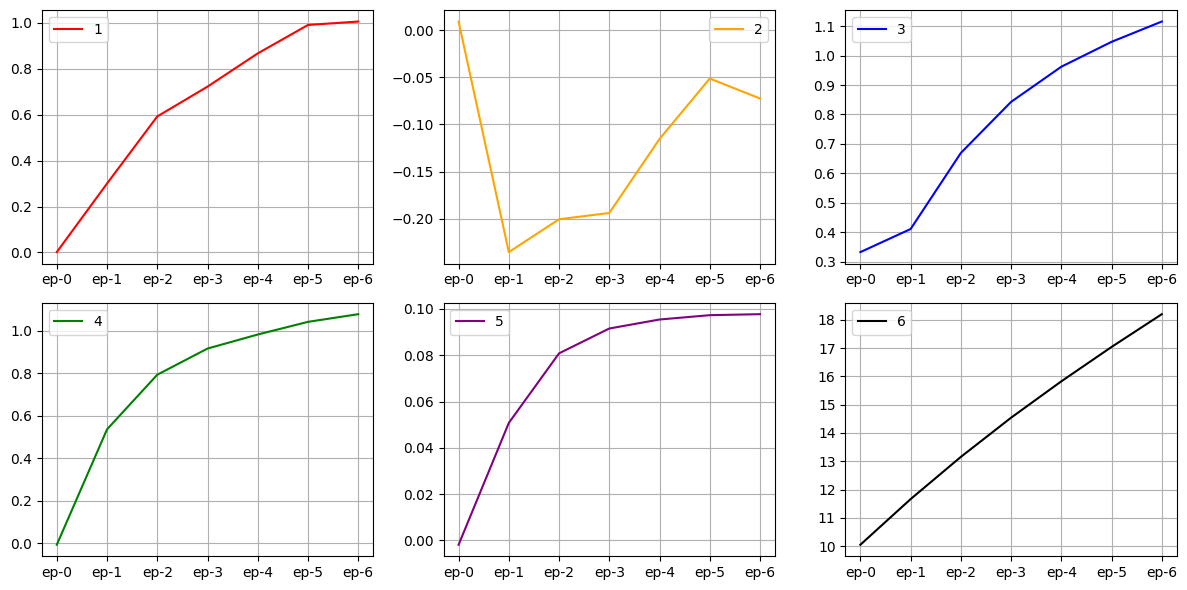

In [36]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 6))

ax1.grid(axis='both')
ax1.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_proj_1"] for v in stats_dict.values()], label = "1", color="red")
ax1.legend()

ax2.grid(axis='both')
ax2.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_noise_proj"] for v in stats_dict.values()], label = "2", color="orange")
ax2.legend()

ax3.grid(axis='both')
ax3.plot(["ep-%d"%x for x in stats_dict.keys()], [v["var_proj_1"] for v in stats_dict.values()], label = "3", color="blue")
ax3.legend()

ax4.grid(axis='both')
ax4.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_proj_2"] for v in stats_dict.values()], label = "4", color="green")
ax4.legend()

ax5.grid(axis='both')
ax5.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_sim"] for v in stats_dict.values()], label = "5", color="purple")
ax5.legend()

ax6.grid(axis='both')
ax6.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_mag"] for v in stats_dict.values()], label = "6", color="black")
ax6.legend()

fig.tight_layout()
fig.show()

# Visualize distributions

In [37]:
test_indexes = range(0, 20)

targets = [list(test_dict.keys())[test_index] for test_index in test_indexes]

print("Visuaizing for: ", targets)

Visuaizing for:  ['televised', 'uruguayan', 'credits', 'geologist', 'commerce', 'greeley', 'desperately', 'heretics', 'broadest', 'fleets', 'salvation', 'sought', 'creationist', 'oliver', 'congresses', 'odysseus', 'thumb', 'factory', 'compulsory', 'servants']


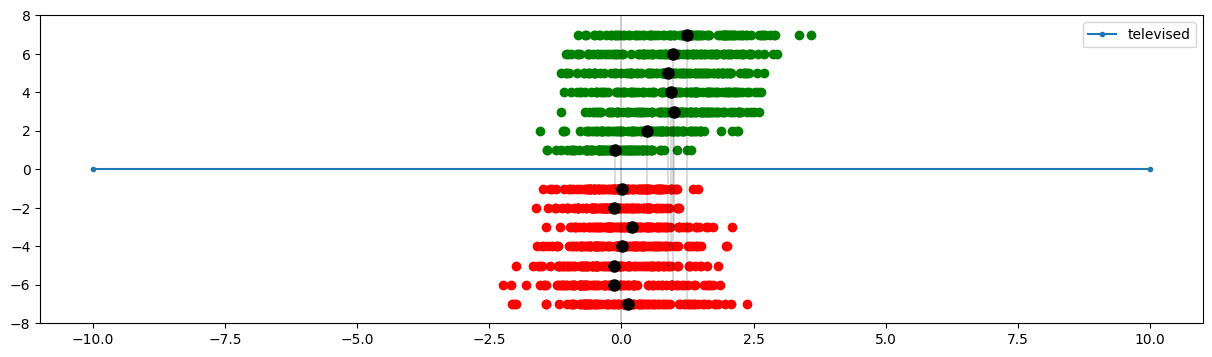

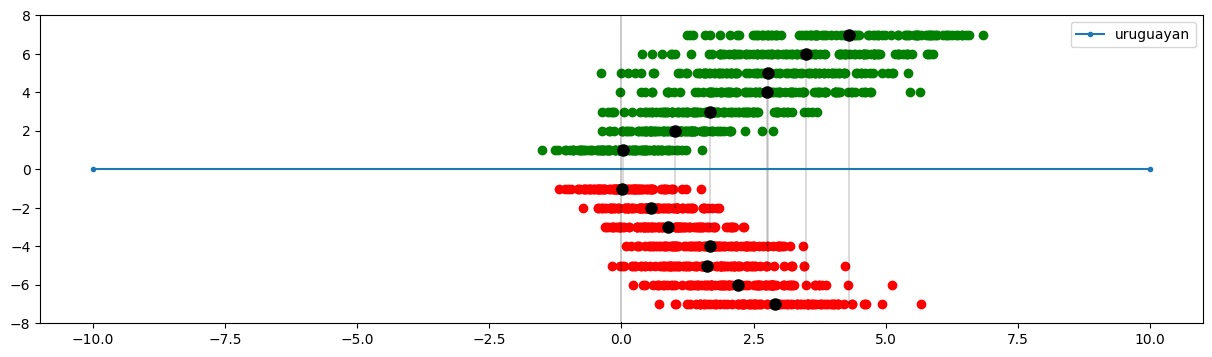

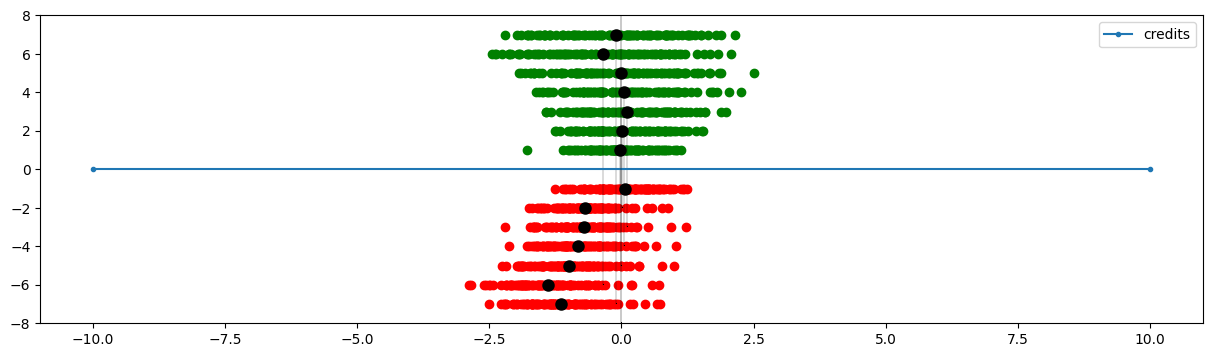

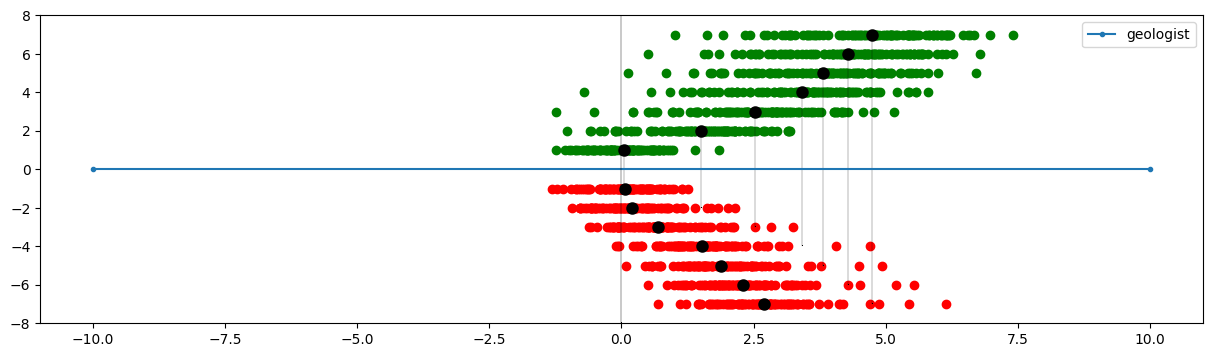

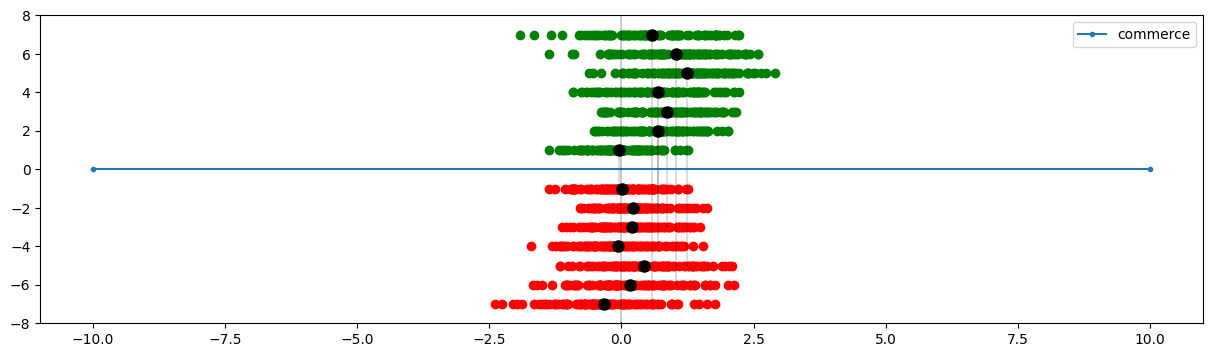

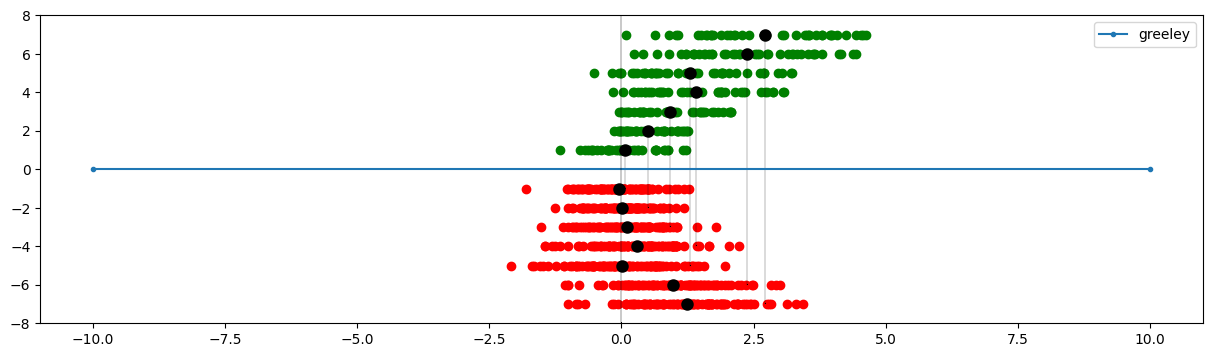

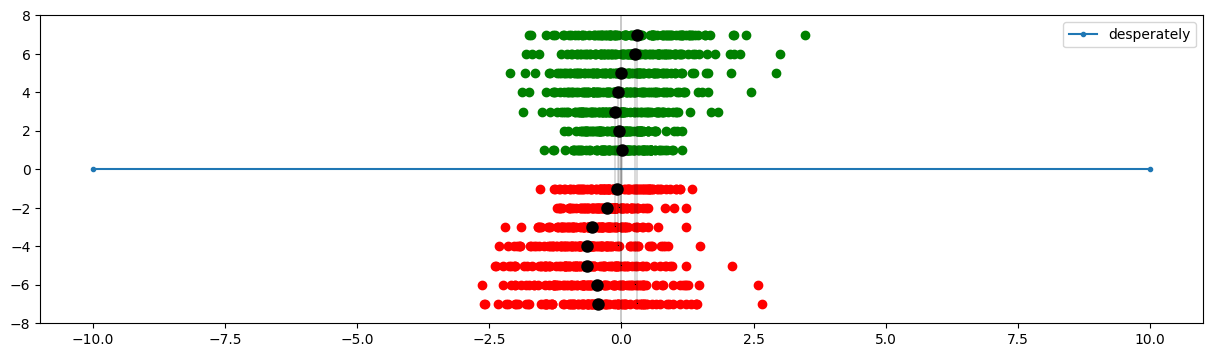

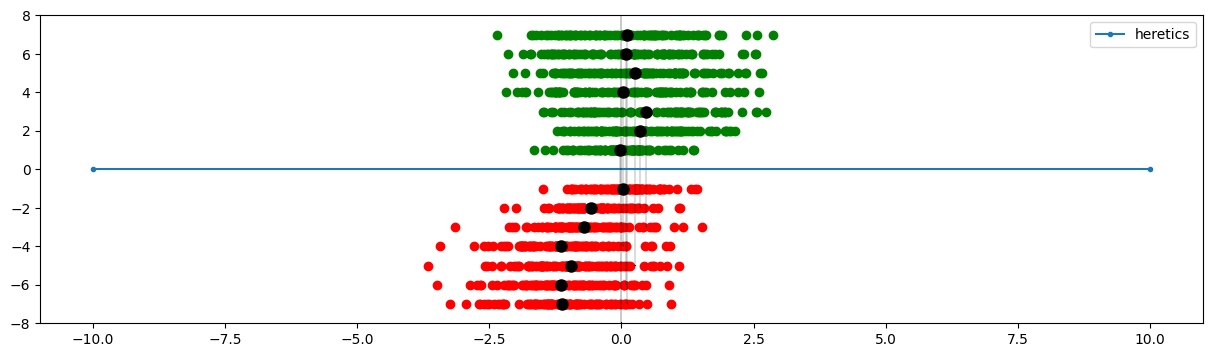

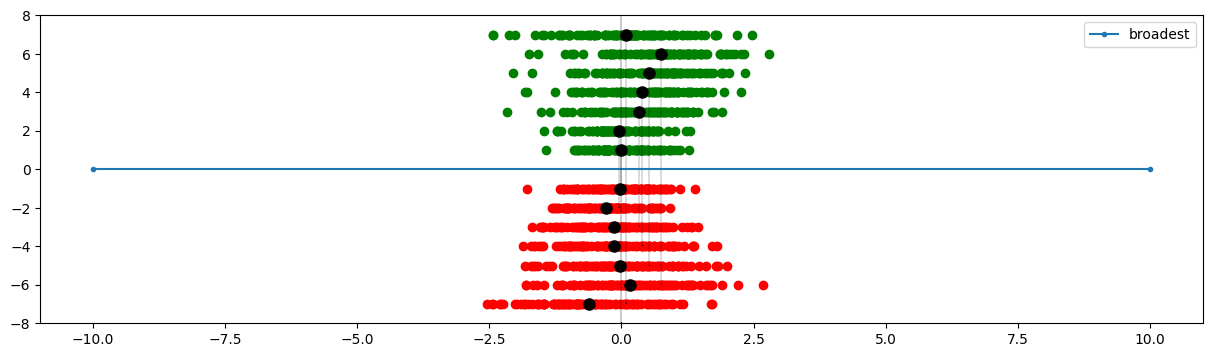

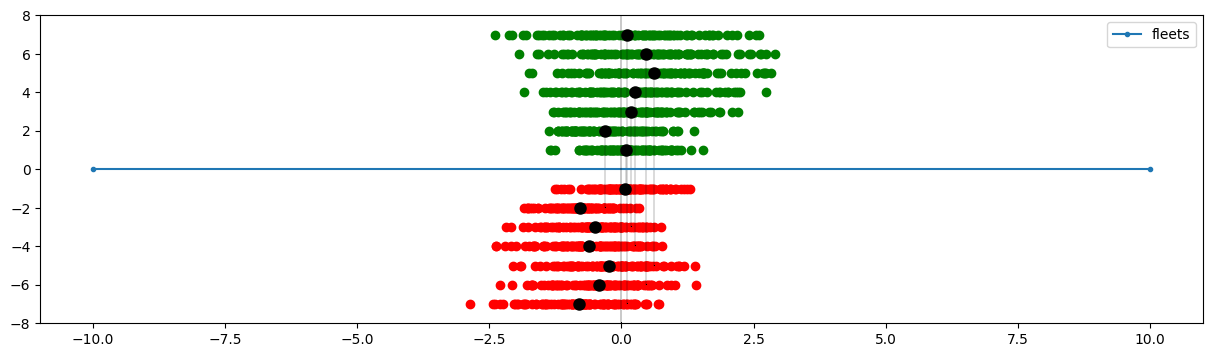

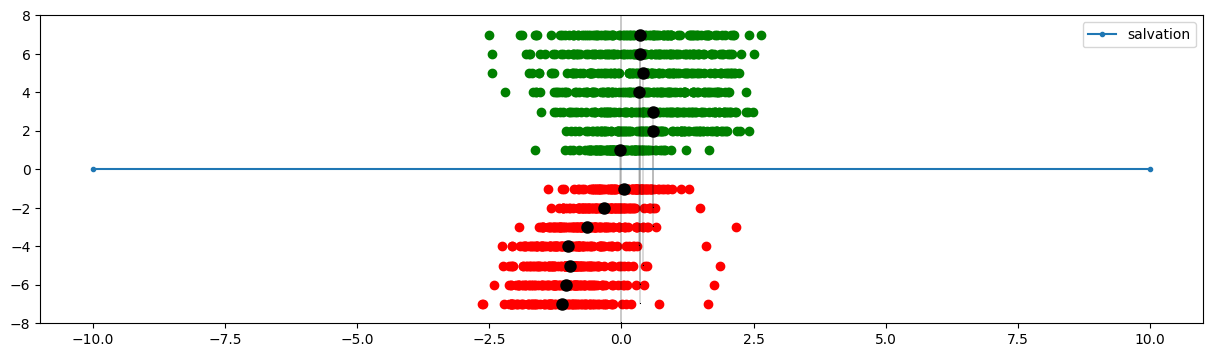

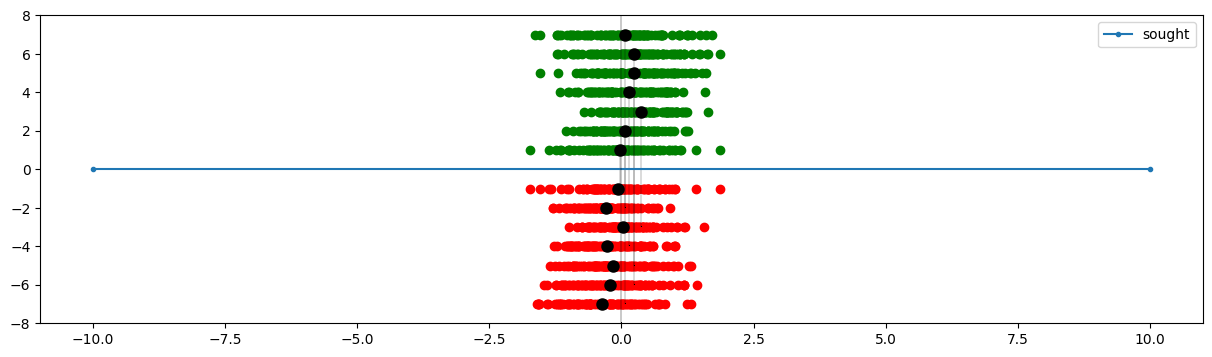

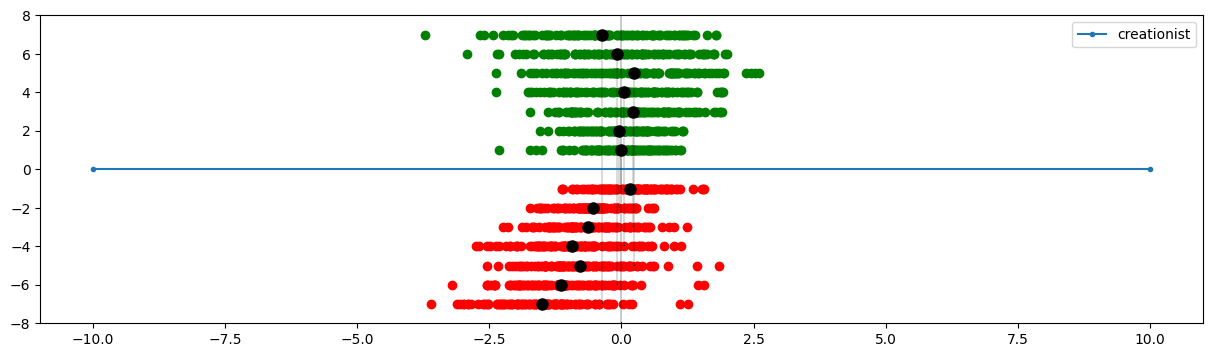

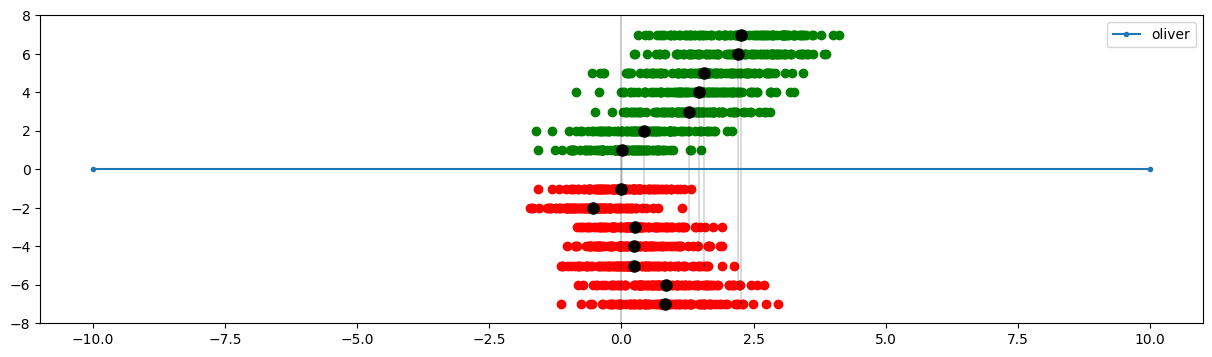

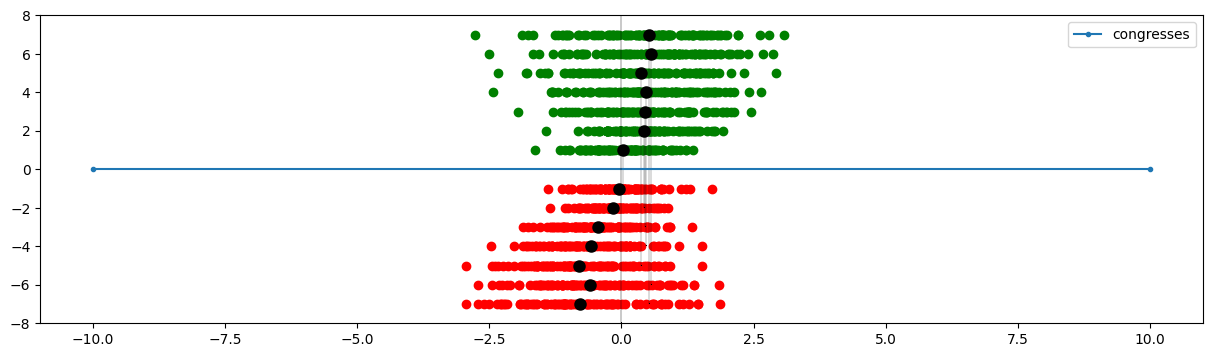

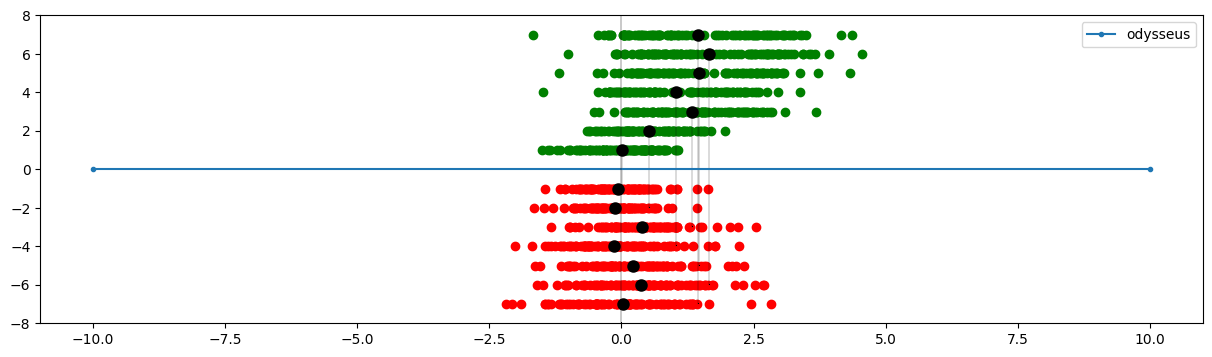

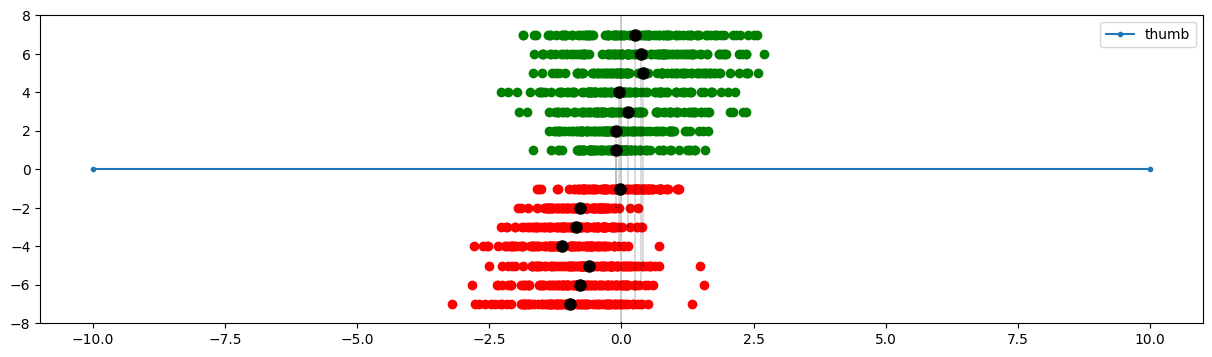

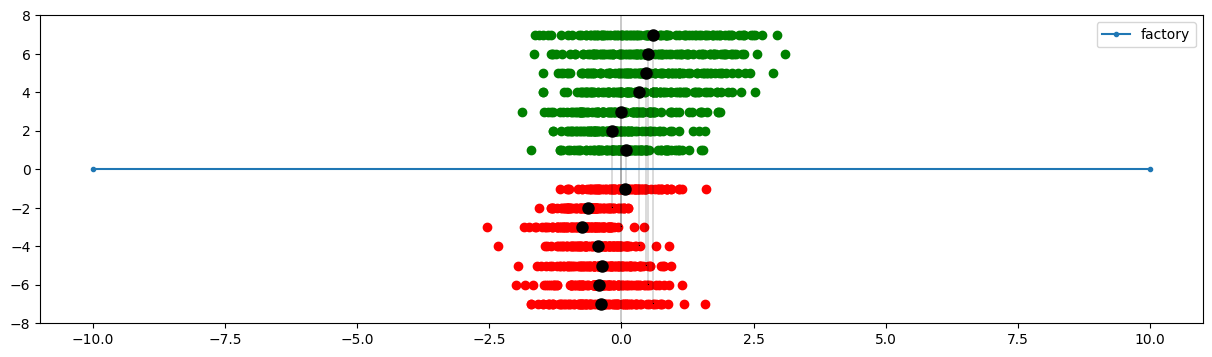

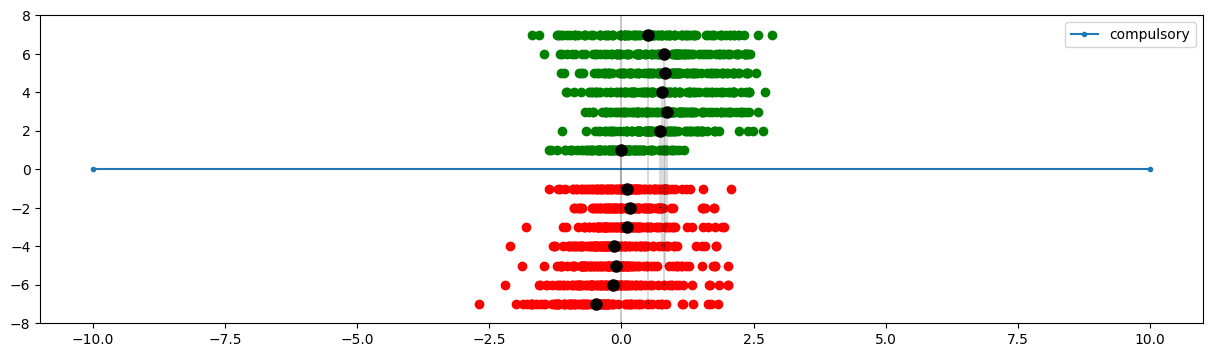

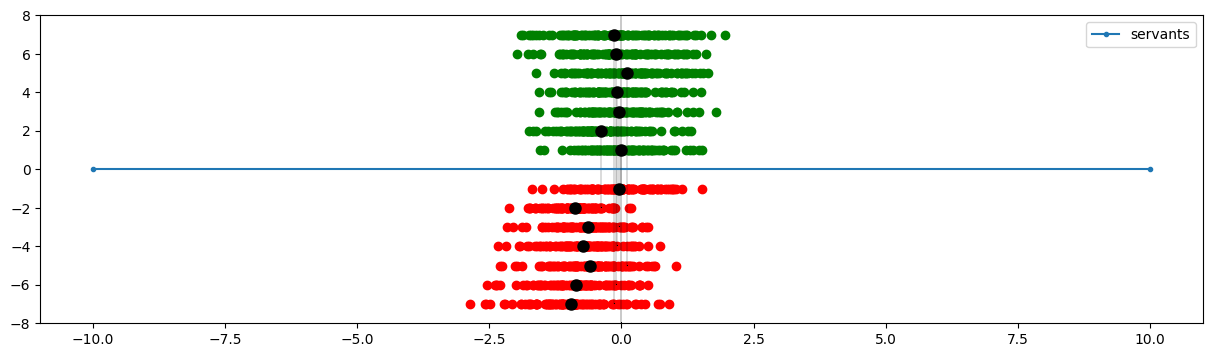

In [38]:
for trg in targets:
  contexts = test_dict[trg]["pos"]
  noises = test_dict[trg]["neg"]

  plt.figure(figsize=(15,4))

  for epoch in range(len(models3)):
    target_vectors = models3[epoch].embedding_input_dictionary()
    context_vectors = models3[epoch].embedding_output_dictionary()

    context_projections = [orthogonal_projection_position(trg, context, target_vectors, context_vectors) for context in contexts]
    noise_projections = [orthogonal_projection_position(trg, context, target_vectors, context_vectors) for context in noises]

    plt.scatter(context_projections, [epoch+1] * len(context_projections), color="green")
    plt.scatter([statistics.mean(context_projections)], [epoch+1], color="black", linewidths=3.0)
    x1, y1 = [statistics.mean(context_projections), statistics.mean(context_projections)], [-(epoch+1), (epoch+1)]
    plt.plot(x1, y1, marker = ',', color="black", linewidth=0.2)

    plt.scatter(noise_projections, [-(epoch+1)] * len(noise_projections), color="red")
    plt.scatter([statistics.mean(noise_projections)], [-(epoch+1)], color="black", linewidths=3.0)

  #magnitude = math.sqrt(sum(i**2 for i in target_vectors[trg]))
  magnitude = 10.0
  x1, y1 = [-magnitude, +magnitude], [0, 0]
  plt.plot(x1, y1, marker = '.', label=trg)

  x1, y1 = [0, 0], [-(epoch+2), (epoch+2)]
  plt.plot(x1, y1, marker = ',', color="black", linewidth=0.3)

  plt.legend()
  plt.ylim((-(epoch+2), (epoch+2)))
  plt.show()

## Clustering projections

In [39]:
cluster_dict = {model_idx: {i:0 for i in range(2,9)} for model_idx in range(len(models3))}
ideal_cluster_dict = {word:[0, 0, list()] for word in test_dict.keys()}

for model_idx in range(len(models3)):

  trg_emb = models3[model_idx].embedding_input_dictionary()
  ctx_emb = models3[model_idx].embedding_output_dictionary()
  counter = 0
  print()

  for word, samples in test_dict.items():

    contexts = samples["pos"]

    ideal_cluster_dict[word][1] = 0
    ideal_cluster_dict[word][0] = 0

    for k in range(2,9):

      score, cluster_indices = kmeans_cluster(k, [orthogonal_projection_position(word, ctx, trg_emb, ctx_emb) for ctx in contexts])
      #clusters = [[contexts[idx] for idx in cluster] for cluster in cluster_indices.values()]

      cluster_dict[model_idx][k] = cluster_dict[model_idx][k] + (score / len(test_dict.items()))

      if ideal_cluster_dict[word][1] < score:
        ideal_cluster_dict[word][1] = score
        ideal_cluster_dict[word][0] = k
    ideal_cluster_dict[word][2].append((ideal_cluster_dict[word][0], ideal_cluster_dict[word][1]))

    counter += 1
    print("\r[MODEL #%d] Progress: %d/%d" % (model_idx, counter, len(test_dict.items())), end='')

  print("\n", cluster_dict[model_idx])


[MODEL #0] Progress: 50/50
 {2: 0.5608897394733822, 3: 0.5505068078618469, 4: 0.5495129883785328, 5: 0.5516921106847872, 6: 0.5523347650927377, 7: 0.5560199763982042, 8: 0.5613784376866041}

[MODEL #1] Progress: 50/50
 {2: 0.5780235665257321, 3: 0.558564908524839, 4: 0.5513238919117744, 5: 0.5540918405543163, 6: 0.559385933039539, 7: 0.5626347945633654, 8: 0.5619231177055236}

[MODEL #2] Progress: 50/50
 {2: 0.5844692596918553, 3: 0.5585719456718786, 4: 0.5554854584829415, 5: 0.5647137498667513, 6: 0.5564940900484829, 7: 0.5506002162988219, 8: 0.5570224039325037}

[MODEL #3] Progress: 50/50
 {2: 0.5861400254288912, 3: 0.5591716748849033, 4: 0.553847396418093, 5: 0.5589152072179354, 6: 0.550281756435879, 7: 0.5526965923425894, 8: 0.5574352766247676}

[MODEL #4] Progress: 50/50
 {2: 0.5856499321565553, 3: 0.5588795539104445, 4: 0.550788121745737, 5: 0.5518745727121389, 6: 0.5495371572293338, 7: 0.5532613600858061, 8: 0.5534393626441937}

[MODEL #5] Progress: 50/50
 {2: 0.579262195444336

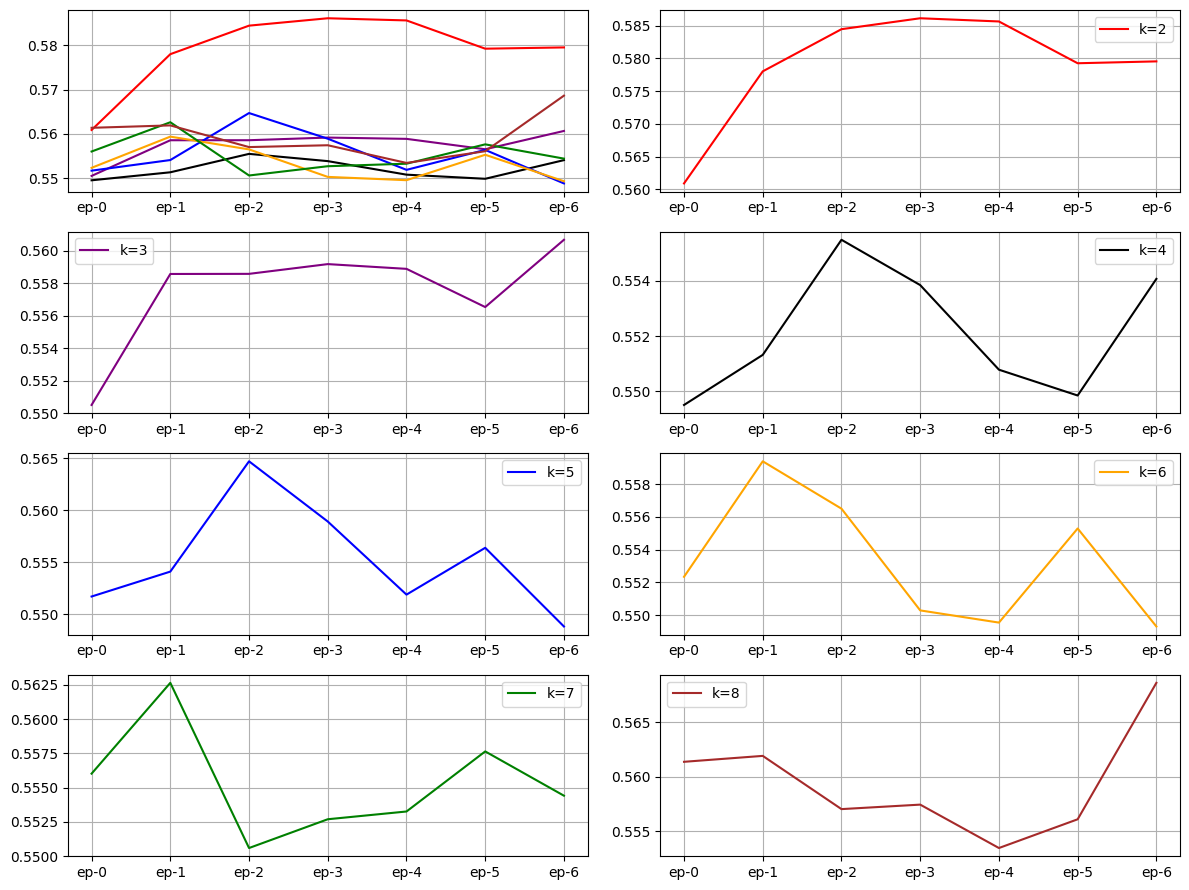

In [40]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(nrows = 4, ncols = 2, figsize = (12, 9))

ax1.grid(axis='both')
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[2] for v in cluster_dict.values()], label = "k=2", color="red")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[3] for v in cluster_dict.values()], label = "k=3", color="purple")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[4] for v in cluster_dict.values()], label = "k=4", color="black")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[5] for v in cluster_dict.values()], label = "k=5", color="blue")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[6] for v in cluster_dict.values()], label = "k=6", color="orange")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[7] for v in cluster_dict.values()], label = "k=7", color="green")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[8] for v in cluster_dict.values()], label = "k=8", color="brown")

ax2.grid(axis='both')
ax2.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[2] for v in cluster_dict.values()], label = "k=2", color="red")
ax2.legend()

ax3.grid(axis='both')
ax3.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[3] for v in cluster_dict.values()], label = "k=3", color="purple")
ax3.legend()

ax4.grid(axis='both')
ax4.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[4] for v in cluster_dict.values()], label = "k=4", color="black")
ax4.legend()

ax5.grid(axis='both')
ax5.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[5] for v in cluster_dict.values()], label = "k=5", color="blue")
ax5.legend()

ax6.grid(axis='both')
ax6.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[6] for v in cluster_dict.values()], label = "k=6", color="orange")
ax6.legend()

ax7.grid(axis='both')
ax7.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[7] for v in cluster_dict.values()], label = "k=7", color="green")
ax7.legend()

ax8.grid(axis='both')
ax8.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[8] for v in cluster_dict.values()], label = "k=8", color="brown")
ax8.legend()


fig.tight_layout()
fig.show()

In [41]:
cluster_table = PrettyTable()
cluster_table.field_names = ["Target", "Ideal Nr of Clusters per Epoch", "Score"]
for word in test_dict.keys():
  cluster_table.add_row([word, [x[0] for x in ideal_cluster_dict[word][2]], ["%.3f"%x[1] for x in ideal_cluster_dict[word][2]]])

print(cluster_table)

+---------------+--------------------------------+-----------------------------------------------------------------+
|     Target    | Ideal Nr of Clusters per Epoch |                              Score                              |
+---------------+--------------------------------+-----------------------------------------------------------------+
|   televised   |     [6, 2, 2, 2, 2, 3, 5]      | ['0.559', '0.589', '0.601', '0.617', '0.591', '0.580', '0.594'] |
|   uruguayan   |     [2, 7, 8, 2, 2, 2, 3]      | ['0.578', '0.584', '0.606', '0.596', '0.591', '0.615', '0.618'] |
|    credits    |     [3, 2, 2, 5, 5, 2, 2]      | ['0.556', '0.645', '0.609', '0.599', '0.596', '0.606', '0.593'] |
|   geologist   |     [6, 4, 5, 2, 2, 2, 8]      | ['0.596', '0.587', '0.586', '0.575', '0.584', '0.602', '0.587'] |
|    commerce   |     [7, 8, 8, 7, 2, 6, 8]      | ['0.592', '0.600', '0.617', '0.594', '0.591', '0.614', '0.602'] |
|    greeley    |     [8, 2, 6, 2, 2, 2, 2]      | ['0.656', '0.

# v26

In [42]:
models4 = models[3]

## Stats

In [43]:
stats_table, stats_dict = get_stats(models4, test_dict)


[MODEL #0] Progress: 50/50
[MODEL #1] Progress: 50/50
[MODEL #2] Progress: 50/50
[MODEL #3] Progress: 50/50
[MODEL #4] Progress: 50/50
[MODEL #5] Progress: 50/50
[MODEL #6] Progress: 50/50

### Stats Dictionary
1. Average context (ctx repr.) projections on target (trg repr.)
2. Average noise (ctx repr.) projections on target (trg repr.)
3. Average ***variance*** of context (ctx repr.) projections on target (trg repr.)
4. Average projection **difference** of context (ctx repr.) and noise (ctx repr.) on target (trg repr.)
5. Average ***cos-similarity*** of context (trg repr.) and target (trg repr.)
6. Average target magnitude

In [44]:
print(stats_table)

+---------------+--------+--------+-------+-------+-------+--------+
|     Target    |   1    |   2    |   3   |   4   |   5   |   6    |
+---------------+--------+--------+-------+-------+-------+--------+
|   televised   | -0.060 | -1.415 | 1.589 | 1.355 | 0.121 | 18.843 |
|   uruguayan   | 3.768  | 2.194  | 2.436 | 1.574 | 0.132 | 15.485 |
|    credits    | -0.722 | -1.812 | 1.256 | 1.090 | 0.082 | 19.285 |
|   geologist   | 5.080  | 2.482  | 2.128 | 2.598 | 0.223 | 18.229 |
|    commerce   | 0.710  | -0.512 | 1.569 | 1.222 | 0.114 | 20.608 |
|    greeley    | 2.049  | 0.219  | 2.675 | 1.830 | 0.113 | 12.291 |
|  desperately  | 0.529  | 0.010  | 1.406 | 0.520 | 0.029 | 18.018 |
|    heretics   | 0.159  | -1.601 | 2.416 | 1.761 | 0.162 | 18.362 |
|    broadest   | -0.077 | -0.573 | 0.983 | 0.496 | 0.054 | 18.362 |
|     fleets    | -0.094 | -1.352 | 1.932 | 1.258 | 0.103 | 18.169 |
|   salvation   | 0.026  | -1.713 | 2.219 | 1.739 | 0.165 | 19.325 |
|     sought    | -0.905 | -1.656 

In [45]:
for model_idx, values in stats_dict.items():
  print("EPOCH #%d [1: %.3f] [2: %.3f] [3: %.3f] [4: %.3f] [5: %.3f] [6: %.3f] " % (model_idx, values["avg_proj_1"], values["avg_noise_proj"], values["var_proj_1"], values["avg_proj_2"], values["avg_sim"], values["avg_mag"]))

EPOCH #0 [1: 0.002] [2: 0.009] [3: 0.332] [4: -0.008] [5: -0.002] [6: 10.047] 
EPOCH #1 [1: 0.299] [2: -0.328] [3: 0.559] [4: 0.627] [5: 0.060] [6: 11.552] 
EPOCH #2 [1: 0.584] [2: -0.375] [3: 1.034] [4: 0.959] [5: 0.096] [6: 13.080] 
EPOCH #3 [1: 0.712] [2: -0.405] [3: 1.317] [4: 1.117] [5: 0.107] [6: 14.478] 
EPOCH #4 [1: 0.872] [2: -0.332] [3: 1.487] [4: 1.204] [5: 0.110] [6: 15.758] 
EPOCH #5 [1: 0.987] [2: -0.288] [3: 1.674] [4: 1.275] [5: 0.111] [6: 17.009] 
EPOCH #6 [1: 1.142] [2: -0.187] [3: 1.874] [4: 1.329] [5: 0.111] [6: 18.155] 


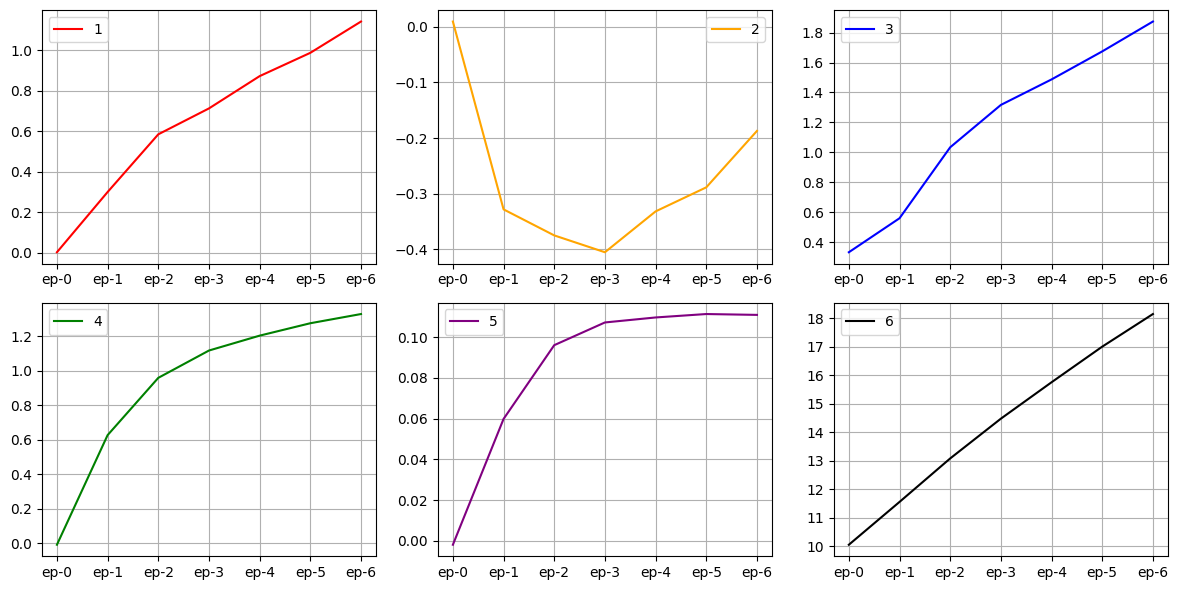

In [46]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 6))

ax1.grid(axis='both')
ax1.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_proj_1"] for v in stats_dict.values()], label = "1", color="red")
ax1.legend()

ax2.grid(axis='both')
ax2.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_noise_proj"] for v in stats_dict.values()], label = "2", color="orange")
ax2.legend()

ax3.grid(axis='both')
ax3.plot(["ep-%d"%x for x in stats_dict.keys()], [v["var_proj_1"] for v in stats_dict.values()], label = "3", color="blue")
ax3.legend()

ax4.grid(axis='both')
ax4.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_proj_2"] for v in stats_dict.values()], label = "4", color="green")
ax4.legend()

ax5.grid(axis='both')
ax5.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_sim"] for v in stats_dict.values()], label = "5", color="purple")
ax5.legend()

ax6.grid(axis='both')
ax6.plot(["ep-%d"%x for x in stats_dict.keys()], [v["avg_mag"] for v in stats_dict.values()], label = "6", color="black")
ax6.legend()

fig.tight_layout()
fig.show()

# Visualize distributions

In [47]:
test_indexes = range(0, 20)

targets = [list(test_dict.keys())[test_index] for test_index in test_indexes]

print("Visuaizing for: ", targets)

Visuaizing for:  ['televised', 'uruguayan', 'credits', 'geologist', 'commerce', 'greeley', 'desperately', 'heretics', 'broadest', 'fleets', 'salvation', 'sought', 'creationist', 'oliver', 'congresses', 'odysseus', 'thumb', 'factory', 'compulsory', 'servants']


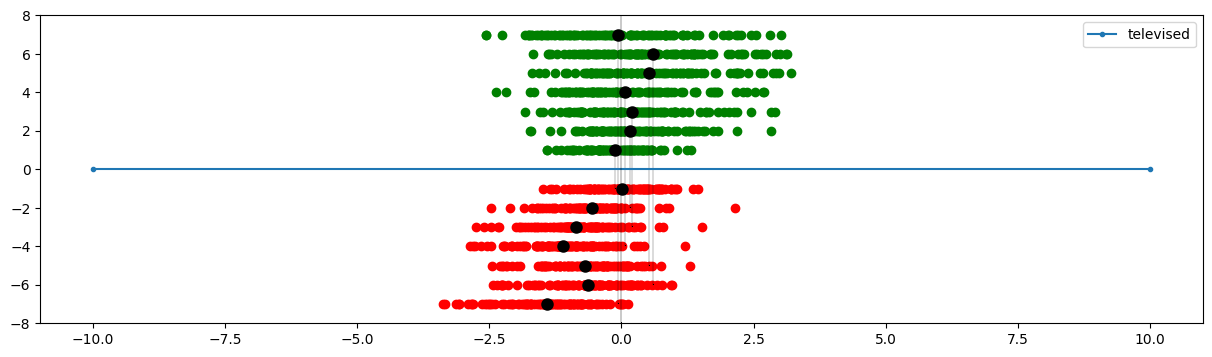

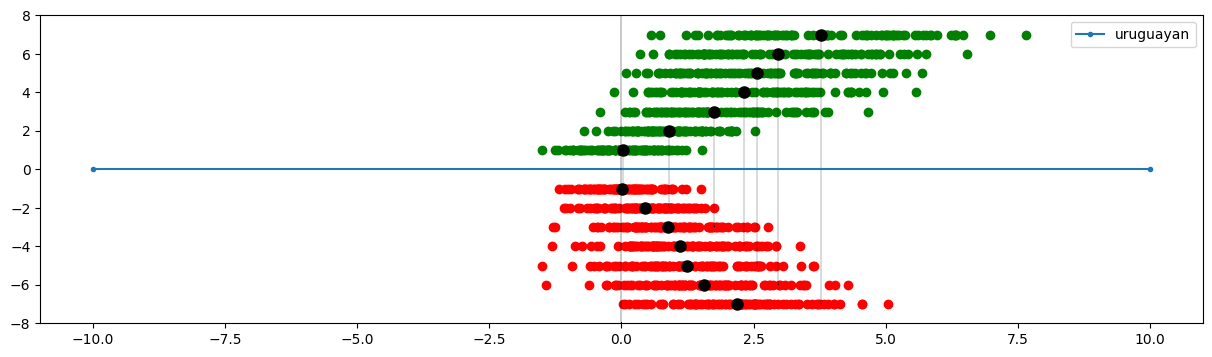

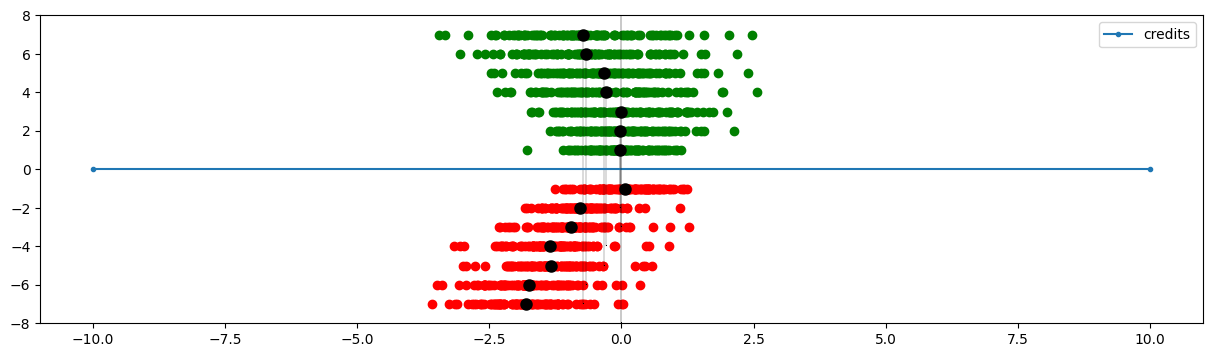

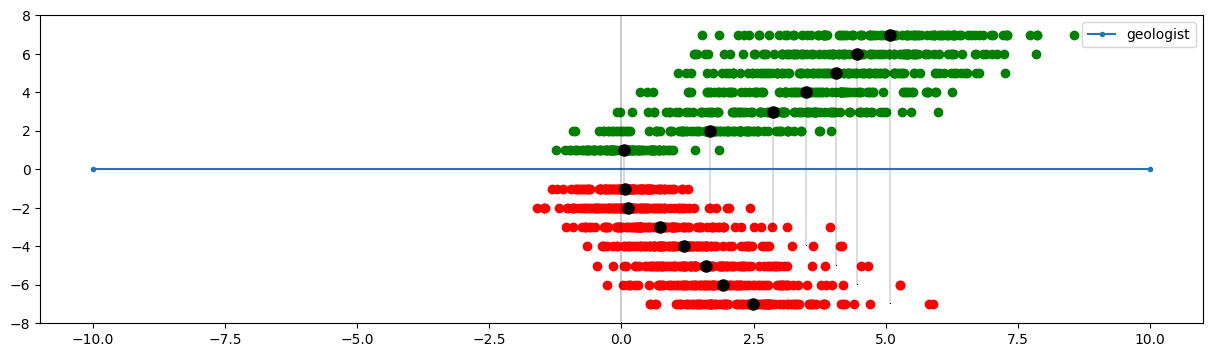

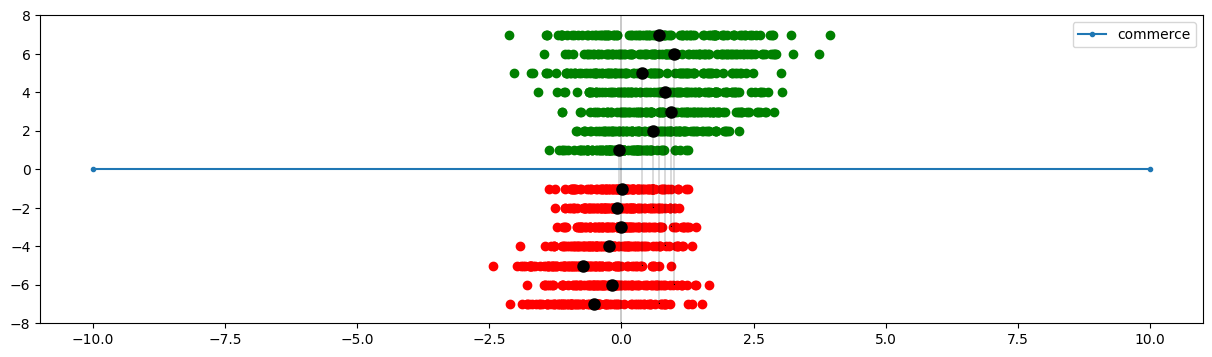

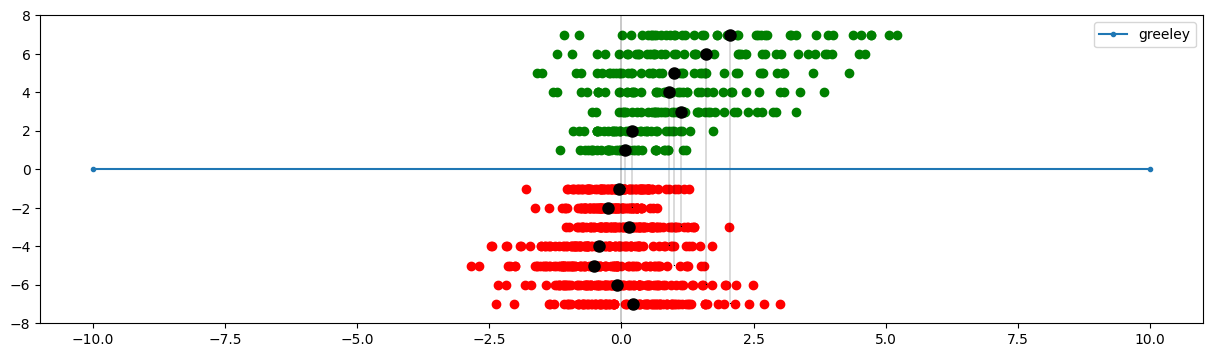

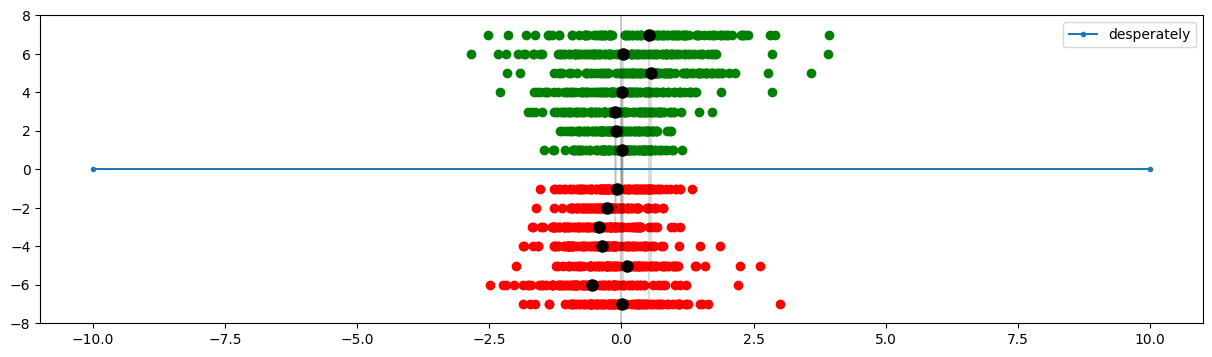

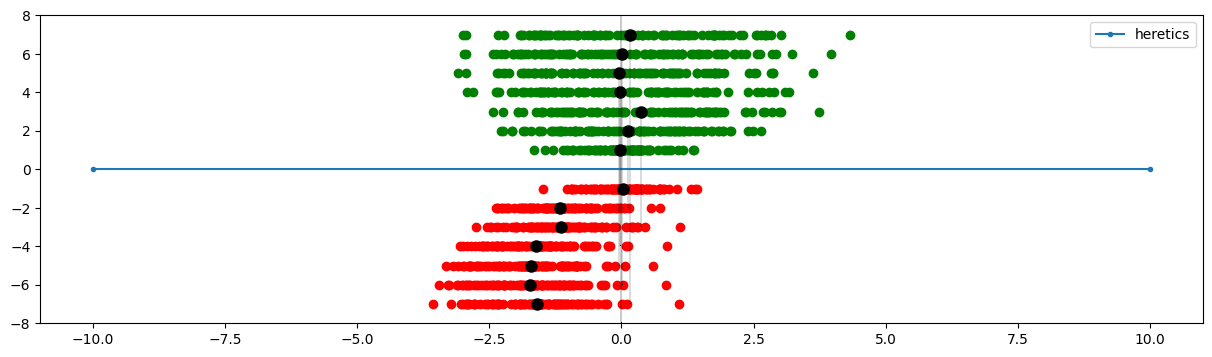

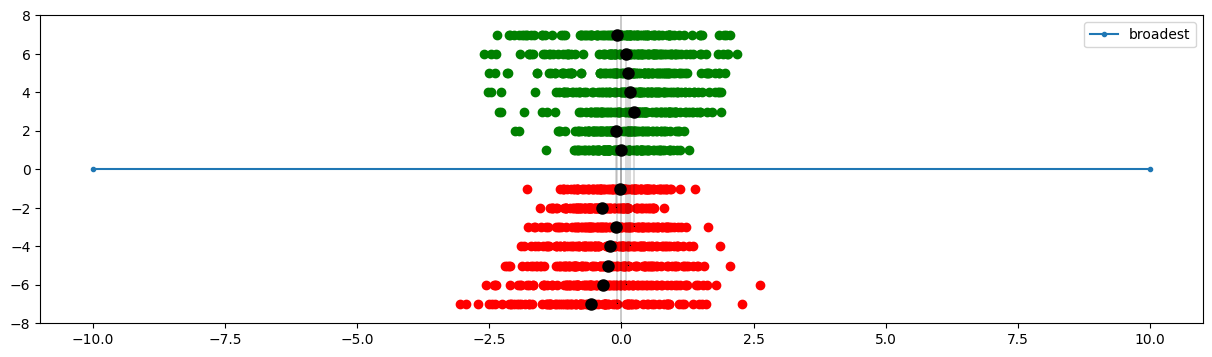

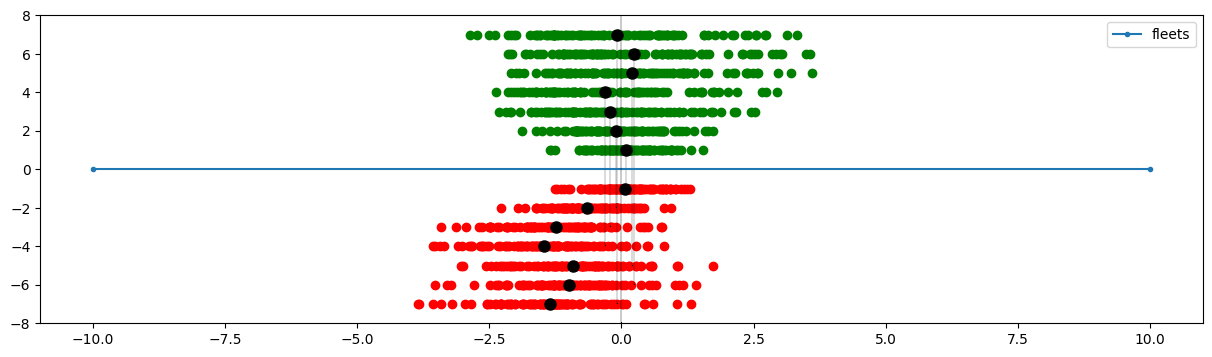

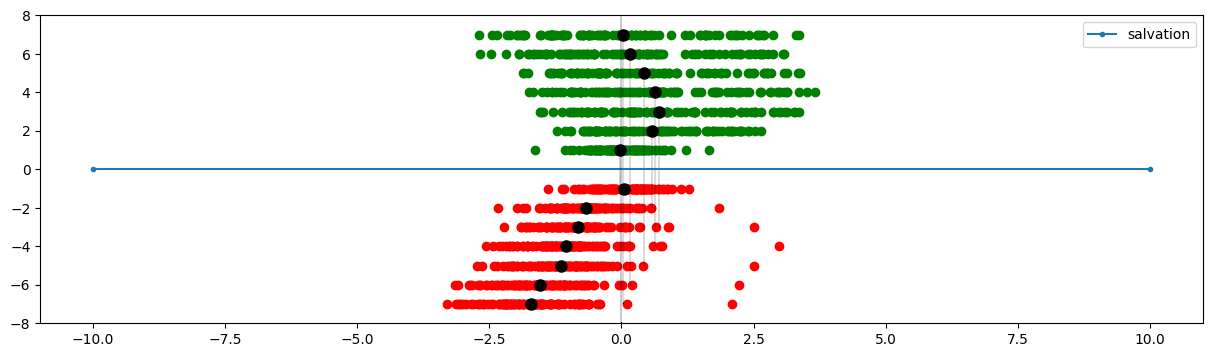

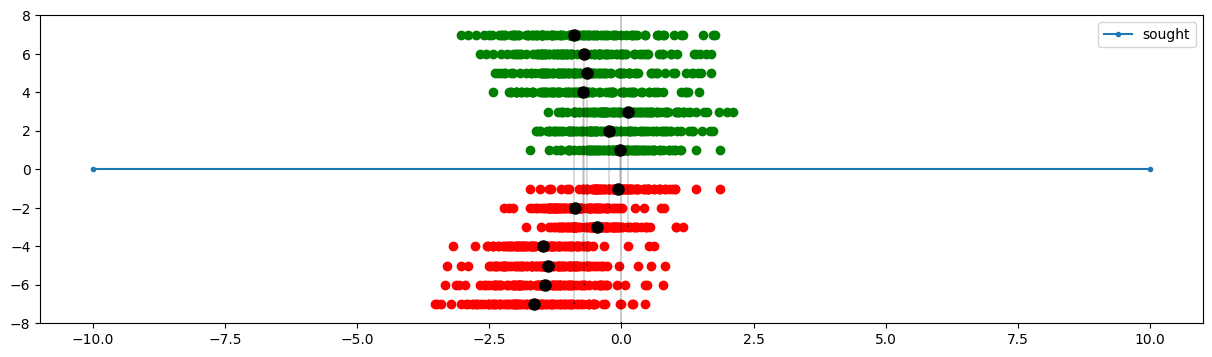

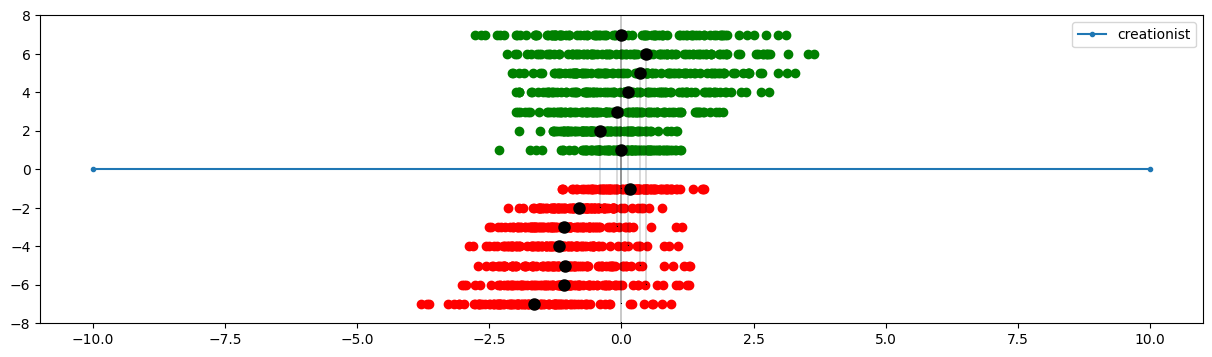

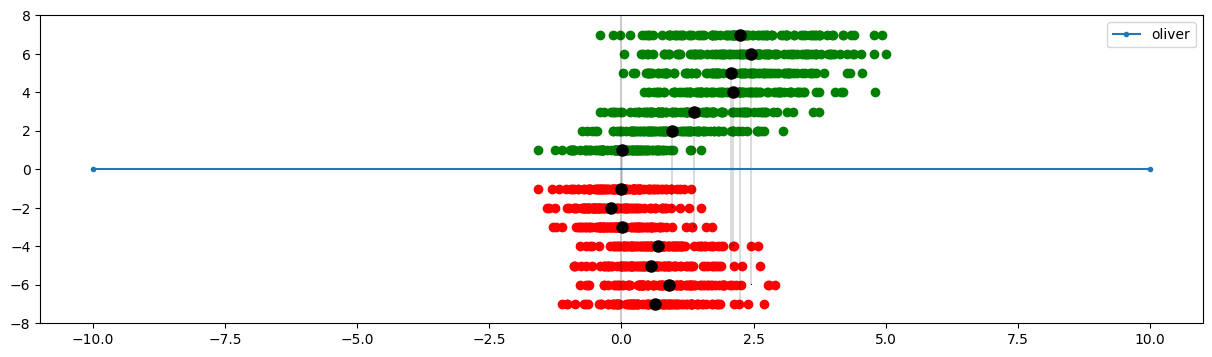

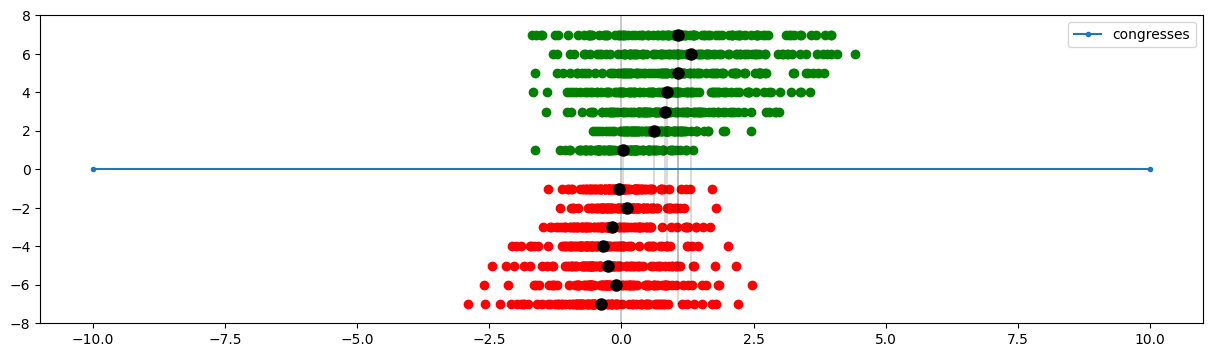

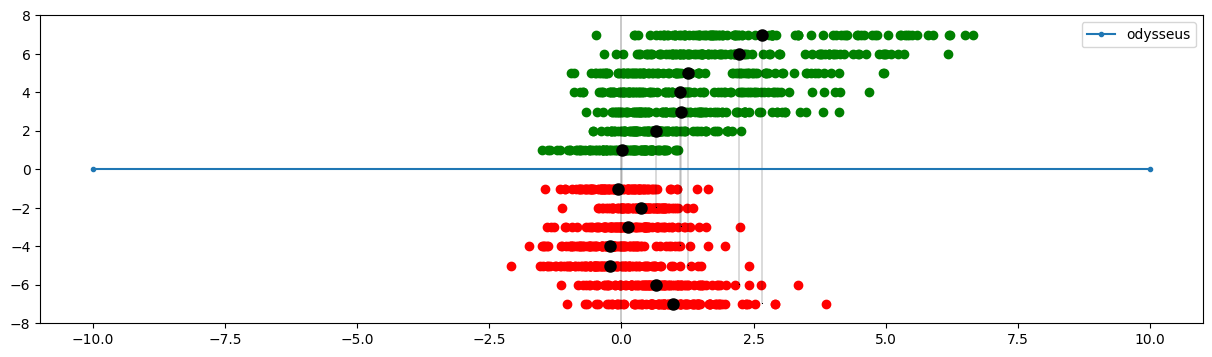

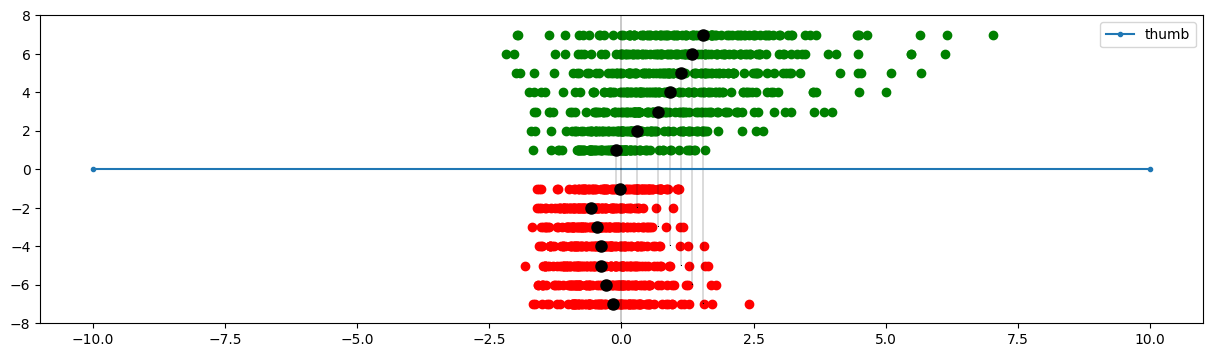

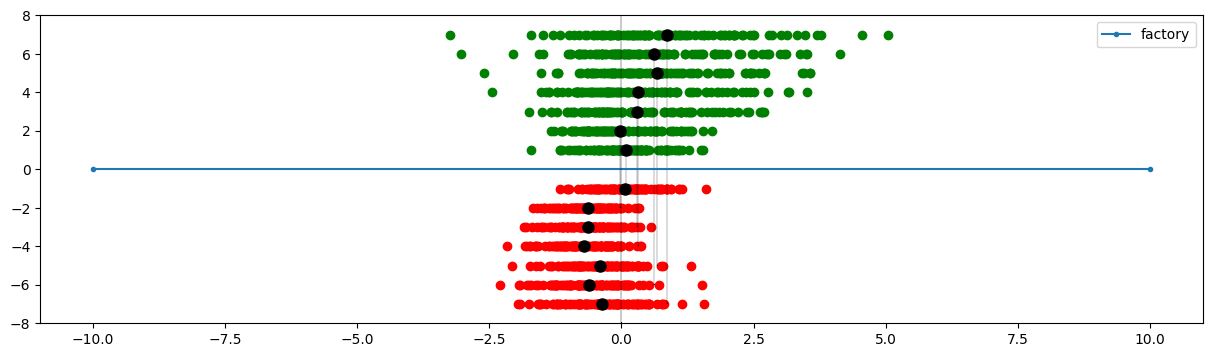

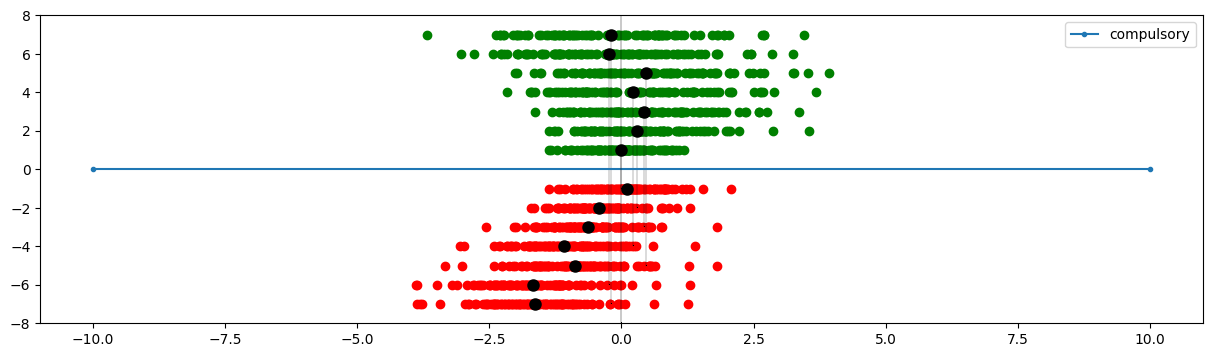

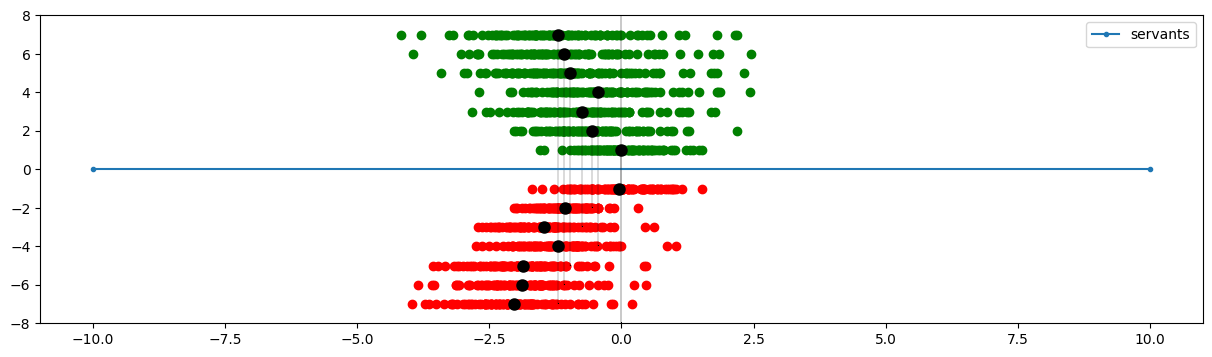

In [48]:
for trg in targets:
  contexts = test_dict[trg]["pos"]
  noises = test_dict[trg]["neg"]

  plt.figure(figsize=(15,4))

  for epoch in range(len(models4)):
    target_vectors = models4[epoch].embedding_input_dictionary()
    context_vectors = models4[epoch].embedding_output_dictionary()

    context_projections = [orthogonal_projection_position(trg, context, target_vectors, context_vectors) for context in contexts]
    noise_projections = [orthogonal_projection_position(trg, context, target_vectors, context_vectors) for context in noises]

    plt.scatter(context_projections, [epoch+1] * len(context_projections), color="green")
    plt.scatter([statistics.mean(context_projections)], [epoch+1], color="black", linewidths=3.0)
    x1, y1 = [statistics.mean(context_projections), statistics.mean(context_projections)], [-(epoch+1), (epoch+1)]
    plt.plot(x1, y1, marker = ',', color="black", linewidth=0.2)

    plt.scatter(noise_projections, [-(epoch+1)] * len(noise_projections), color="red")
    plt.scatter([statistics.mean(noise_projections)], [-(epoch+1)], color="black", linewidths=3.0)

  #magnitude = math.sqrt(sum(i**2 for i in target_vectors[trg]))
  magnitude = 10.0
  x1, y1 = [-magnitude, +magnitude], [0, 0]
  plt.plot(x1, y1, marker = '.', label=trg)

  x1, y1 = [0, 0], [-(epoch+2), (epoch+2)]
  plt.plot(x1, y1, marker = ',', color="black", linewidth=0.3)

  plt.legend()
  plt.ylim((-(epoch+2), (epoch+2)))
  plt.show()

## Clustering projections

In [49]:
cluster_dict = {model_idx: {i:0 for i in range(2,9)} for model_idx in range(len(models4))}
ideal_cluster_dict = {word:[0, 0, list()] for word in test_dict.keys()}

for model_idx in range(len(models4)):

  trg_emb = models4[model_idx].embedding_input_dictionary()
  ctx_emb = models4[model_idx].embedding_output_dictionary()
  counter = 0
  print()

  for word, samples in test_dict.items():

    contexts = samples["pos"]

    ideal_cluster_dict[word][1] = 0
    ideal_cluster_dict[word][0] = 0

    for k in range(2,9):

      score, cluster_indices = kmeans_cluster(k, [orthogonal_projection_position(word, ctx, trg_emb, ctx_emb) for ctx in contexts])
      #clusters = [[contexts[idx] for idx in cluster] for cluster in cluster_indices.values()]

      cluster_dict[model_idx][k] = cluster_dict[model_idx][k] + (score / len(test_dict.items()))

      if ideal_cluster_dict[word][1] < score:
        ideal_cluster_dict[word][1] = score
        ideal_cluster_dict[word][0] = k
    ideal_cluster_dict[word][2].append((ideal_cluster_dict[word][0], ideal_cluster_dict[word][1]))

    counter += 1
    print("\r[MODEL #%d] Progress: %d/%d" % (model_idx, counter, len(test_dict.items())), end='')

  print("\n", cluster_dict[model_idx])


[MODEL #0] Progress: 50/50
 {2: 0.5608897394733822, 3: 0.5505068078618469, 4: 0.5495129883785328, 5: 0.5516921106847872, 6: 0.5523347650927377, 7: 0.5560199763982042, 8: 0.5613784376866041}

[MODEL #1] Progress: 50/50
 {2: 0.5771148425327227, 3: 0.5467590221437736, 4: 0.5472392120920527, 5: 0.5495646173912129, 6: 0.549775674421604, 7: 0.5514861262730788, 8: 0.5548206561194682}

[MODEL #2] Progress: 50/50
 {2: 0.5836005568076791, 3: 0.5538909141424289, 4: 0.5482633901340844, 5: 0.5510854437636236, 6: 0.5517978075735382, 7: 0.5551811000194136, 8: 0.5596212018437571}

[MODEL #3] Progress: 50/50
 {2: 0.585048590242822, 3: 0.5615625883662018, 4: 0.5523338060410485, 5: 0.5573429127992908, 6: 0.5483484857332015, 7: 0.5522384468715975, 8: 0.5569039399336166}

[MODEL #4] Progress: 50/50
 {2: 0.5900111231368639, 3: 0.5611206478672801, 4: 0.5522625752545904, 5: 0.5572394575497486, 6: 0.5569946196519303, 7: 0.5633997178832941, 8: 0.5658892528799039}

[MODEL #5] Progress: 50/50
 {2: 0.592155069062

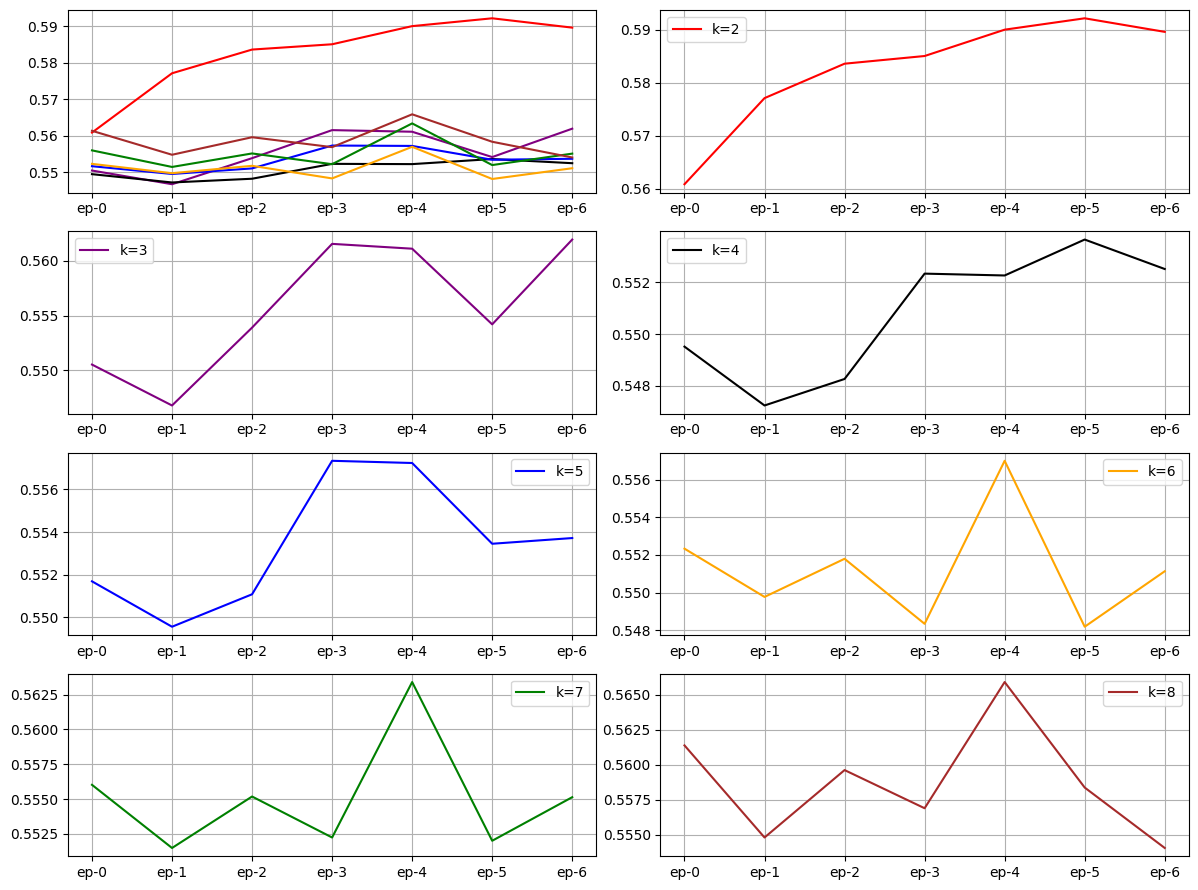

In [50]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(nrows = 4, ncols = 2, figsize = (12, 9))

ax1.grid(axis='both')
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[2] for v in cluster_dict.values()], label = "k=2", color="red")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[3] for v in cluster_dict.values()], label = "k=3", color="purple")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[4] for v in cluster_dict.values()], label = "k=4", color="black")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[5] for v in cluster_dict.values()], label = "k=5", color="blue")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[6] for v in cluster_dict.values()], label = "k=6", color="orange")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[7] for v in cluster_dict.values()], label = "k=7", color="green")
ax1.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[8] for v in cluster_dict.values()], label = "k=8", color="brown")

ax2.grid(axis='both')
ax2.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[2] for v in cluster_dict.values()], label = "k=2", color="red")
ax2.legend()

ax3.grid(axis='both')
ax3.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[3] for v in cluster_dict.values()], label = "k=3", color="purple")
ax3.legend()

ax4.grid(axis='both')
ax4.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[4] for v in cluster_dict.values()], label = "k=4", color="black")
ax4.legend()

ax5.grid(axis='both')
ax5.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[5] for v in cluster_dict.values()], label = "k=5", color="blue")
ax5.legend()

ax6.grid(axis='both')
ax6.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[6] for v in cluster_dict.values()], label = "k=6", color="orange")
ax6.legend()

ax7.grid(axis='both')
ax7.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[7] for v in cluster_dict.values()], label = "k=7", color="green")
ax7.legend()

ax8.grid(axis='both')
ax8.plot(["ep-%d"%(x) for x in cluster_dict.keys()], [v[8] for v in cluster_dict.values()], label = "k=8", color="brown")
ax8.legend()


fig.tight_layout()
fig.show()

In [51]:
cluster_table = PrettyTable()
cluster_table.field_names = ["Target", "Ideal Nr of Clusters per Epoch", "Score"]
for word in test_dict.keys():
  cluster_table.add_row([word, [x[0] for x in ideal_cluster_dict[word][2]], ["%.3f"%x[1] for x in ideal_cluster_dict[word][2]]])

print(cluster_table)

+---------------+--------------------------------+-----------------------------------------------------------------+
|     Target    | Ideal Nr of Clusters per Epoch |                              Score                              |
+---------------+--------------------------------+-----------------------------------------------------------------+
|   televised   |     [6, 2, 3, 2, 2, 4, 2]      | ['0.559', '0.589', '0.571', '0.592', '0.605', '0.613', '0.585'] |
|   uruguayan   |     [2, 8, 2, 2, 2, 2, 2]      | ['0.578', '0.581', '0.630', '0.628', '0.623', '0.635', '0.653'] |
|    credits    |     [3, 2, 2, 2, 2, 7, 3]      | ['0.556', '0.574', '0.611', '0.612', '0.556', '0.583', '0.563'] |
|   geologist   |     [6, 2, 8, 5, 2, 5, 2]      | ['0.596', '0.598', '0.585', '0.611', '0.566', '0.601', '0.570'] |
|    commerce   |     [7, 2, 2, 2, 2, 2, 2]      | ['0.592', '0.578', '0.629', '0.615', '0.618', '0.620', '0.585'] |
|    greeley    |     [8, 7, 2, 6, 8, 2, 2]      | ['0.656', '0.

# Instead of "Context Word" Projections, Visualize "Context" Projections

In the plot below, for each given target word vector, the marks represent the average projection of context embeddings of each context.

In other words, one scatter represents the average projection of all the sorrounding words for one occurance of the target word.

In [52]:
context_dict = {x : list() for x in test_words}
window_size = 3

for idx, w in enumerate(words):
  if w in test_words:
    start , end = max(0 , idx-window_size) , min(len(words)-1 , idx+window_size) + 1
    ctx_samples = [s for s in words[start:idx] + words[idx+1:end] if s != w]
    context_dict[w].append(ctx_samples)

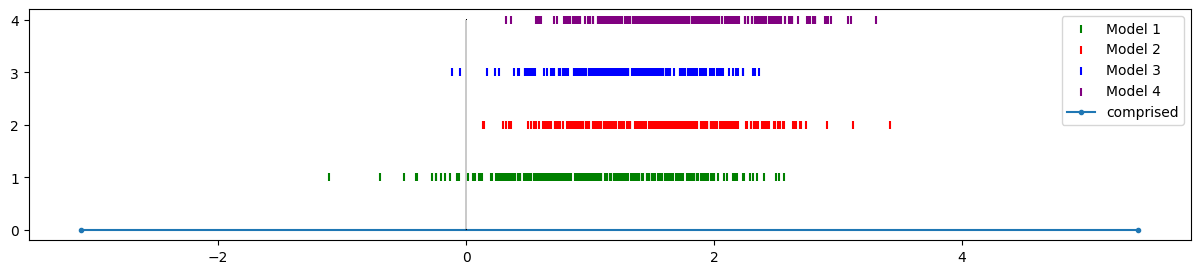

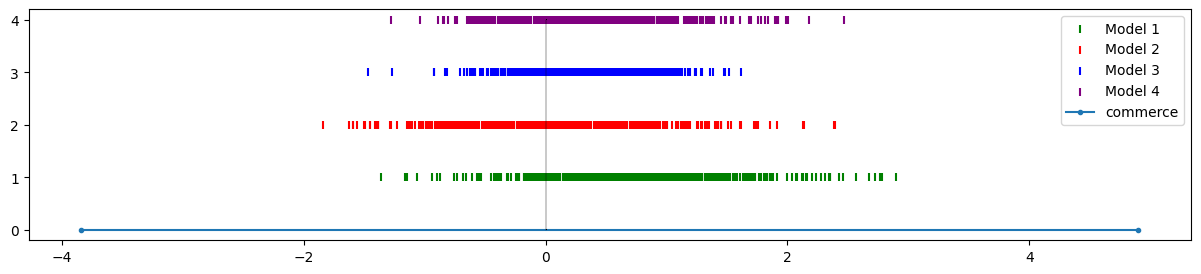

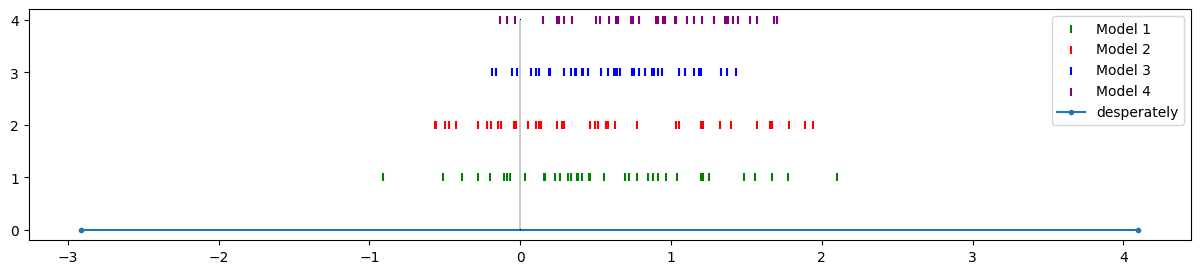

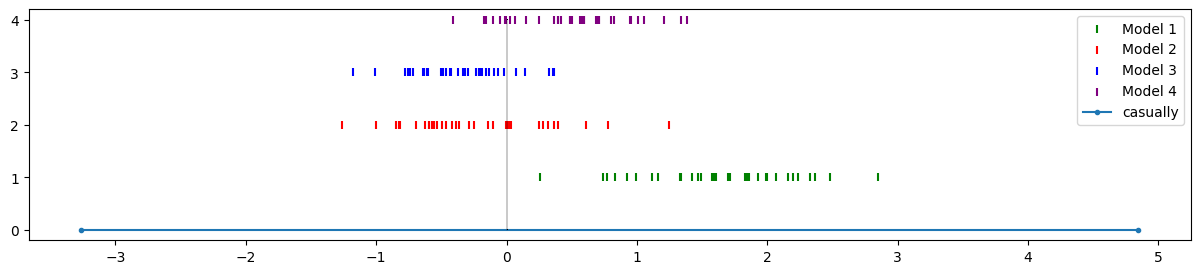

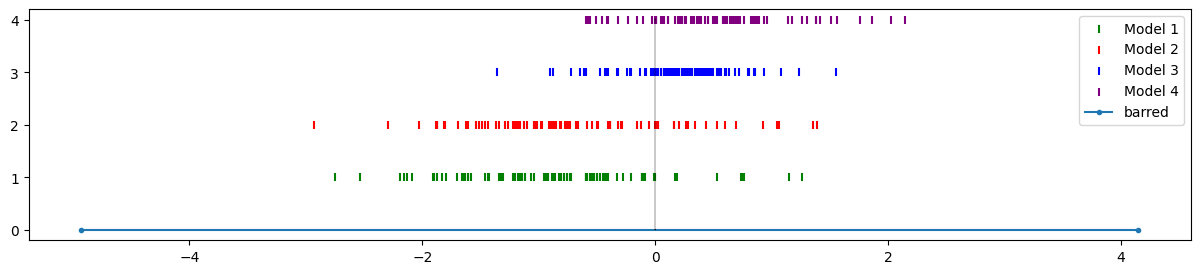

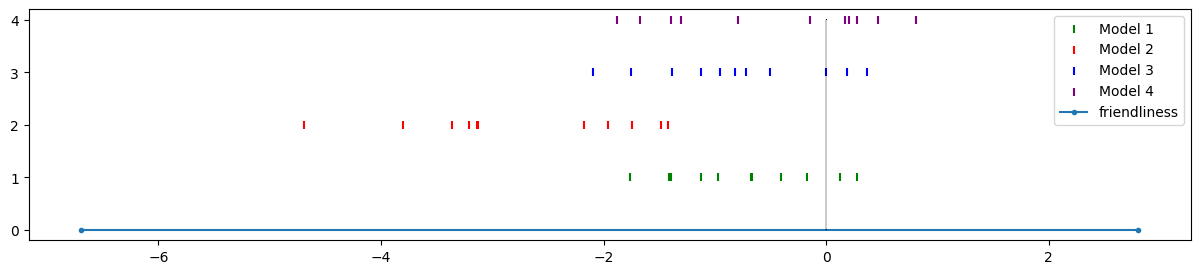

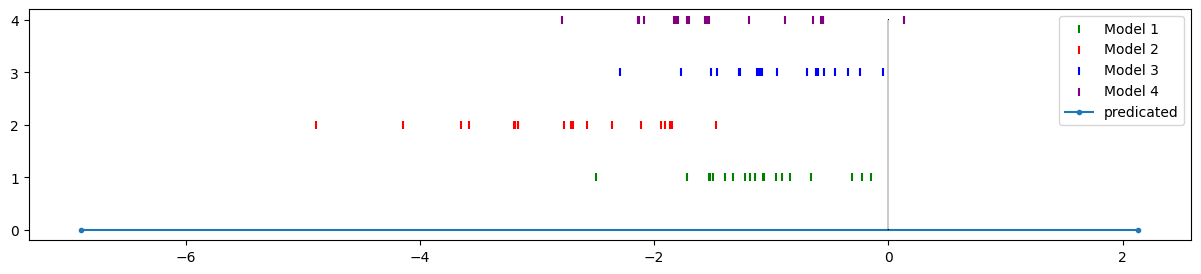

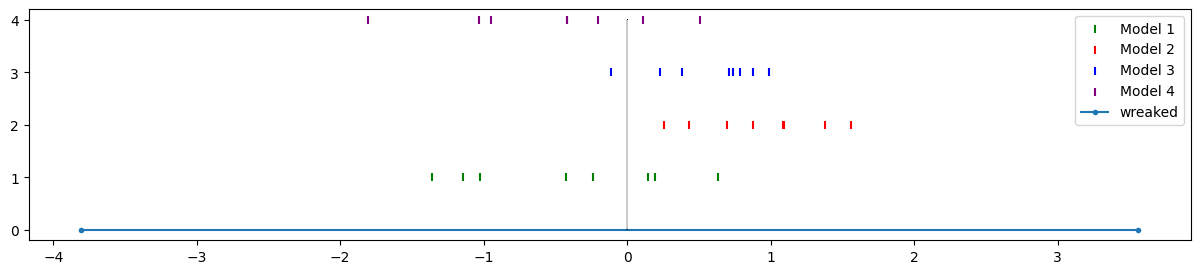

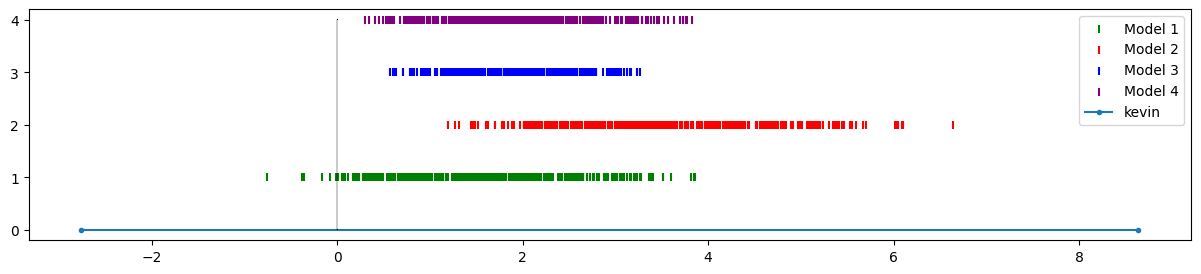

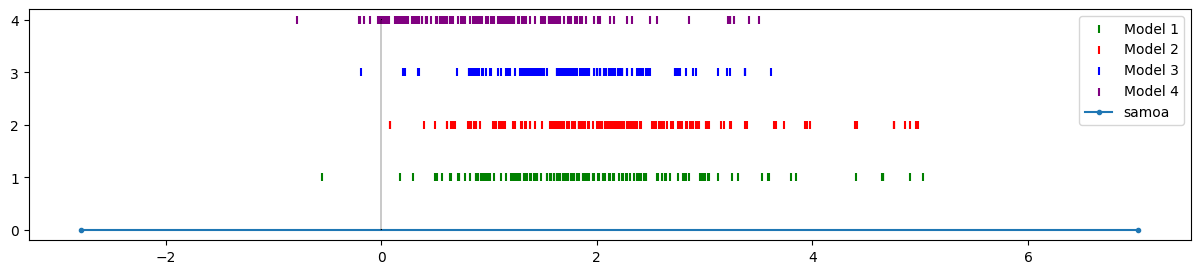

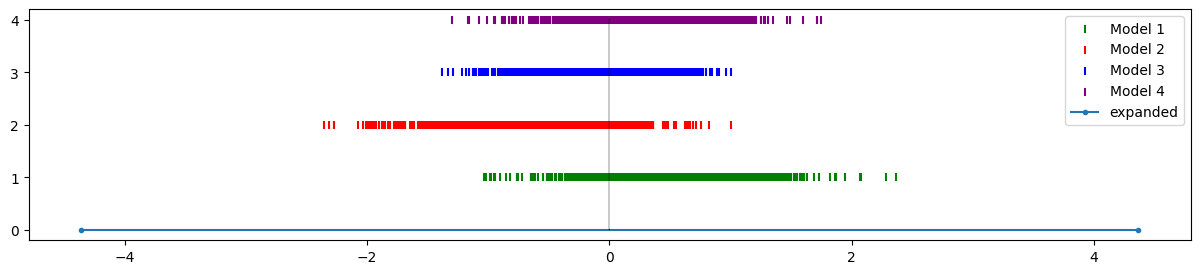

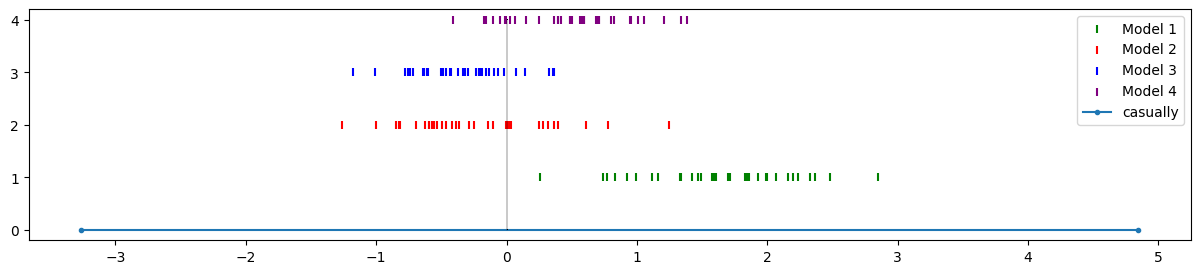

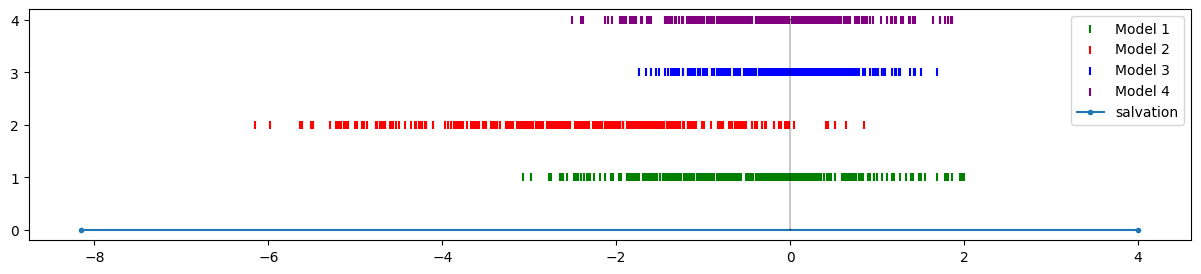

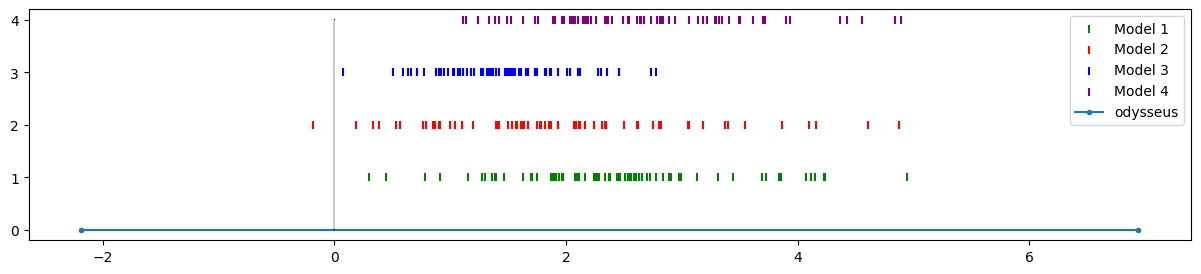

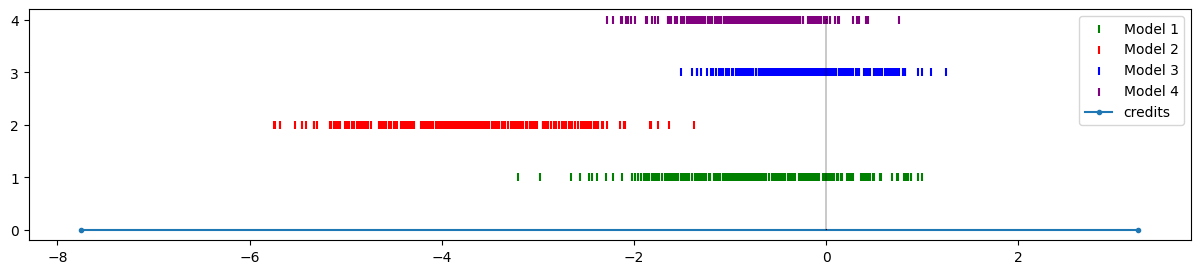

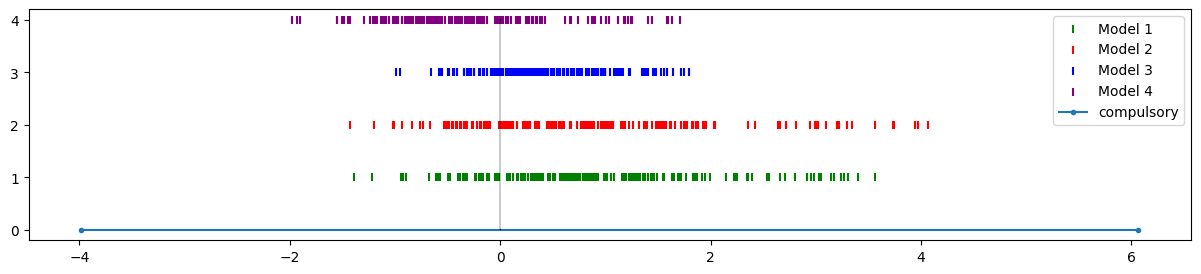

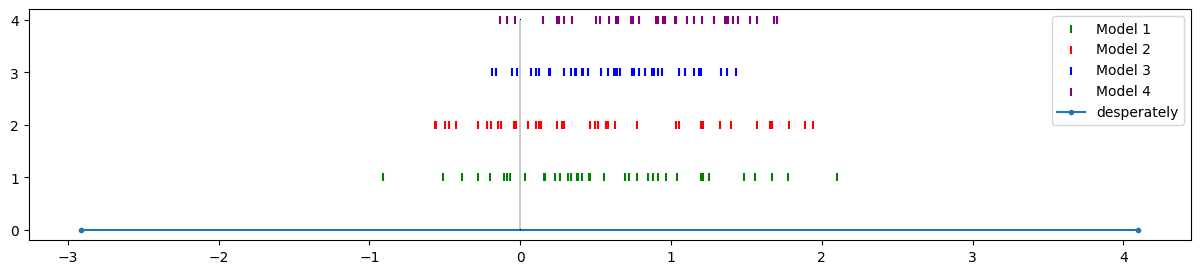

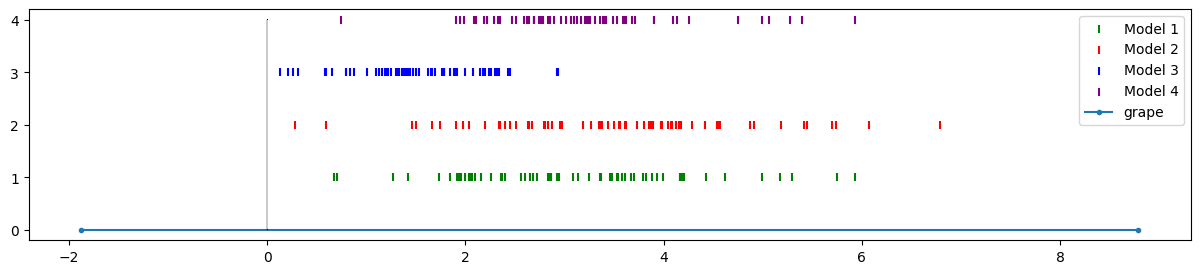

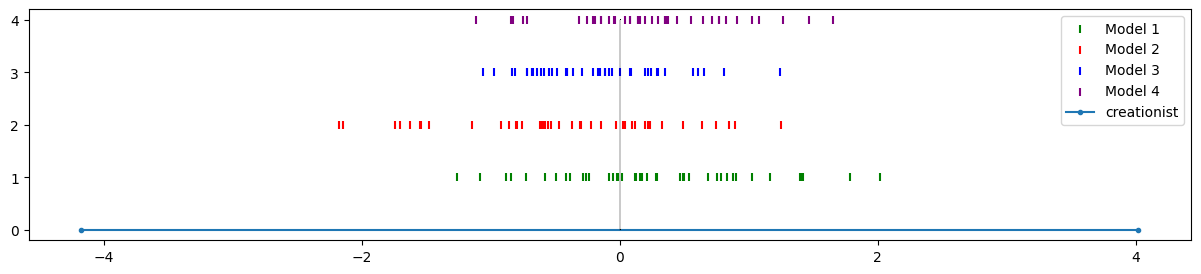

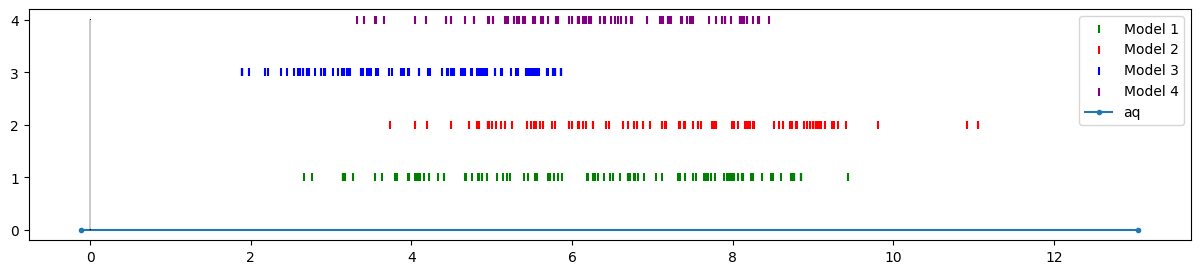

In [ ]:
trgs = np.random.choice(list(context_dict.keys()), size=(20))

for trg in trgs:
  mins, maxes = list(), list()
  plt.figure(figsize=(15,3))

  contexts1 = get_context_projections(models1[-1], context_dict, trg)
  mins.append(min(contexts1))
  maxes.append(max(contexts1))
  plt.scatter(contexts1, [1] * len(contexts1), marker = '|', color="green", label="Model 1")

  contexts2 = get_context_projections(models2[-1], context_dict, trg)
  mins.append(min(contexts2))
  maxes.append(max(contexts2))
  plt.scatter(contexts2, [2] * len(contexts2), marker = '|', color="red", label="Model 2")

  contexts3 = get_context_projections(models3[-1], context_dict, trg)
  mins.append(min(contexts3))
  maxes.append(max(contexts3))
  plt.scatter(contexts3, [3] * len(contexts3), marker = '|', color="blue", label="Model 3")

  contexts4 = get_context_projections(models4[-1], context_dict, trg)
  mins.append(min(contexts4))
  maxes.append(max(contexts4))
  plt.scatter(contexts4, [4] * len(contexts4), marker = '|', color="purple", label="Model 4")

  #magnitude = math.sqrt(sum(i**2 for i in target_vectors[trg]))
  x1, y1 = [min(mins)-2, max(maxes)+2], [0, 0]
  plt.plot(x1, y1, marker = '.', label=trg)

  x1, y1 = [0, 0], [0, 4]
  plt.plot(x1, y1, marker = ',', color="black", linewidth=0.3)

  plt.legend()
  plt.show()

# DC

In [ ]:
from google.colab import runtime
runtime.unassign()